README:  
Introcuction: This script is for figure 5 in fullscope analysis(isoform feature analysis)  
Author: Y0NEKO  
Time: 2024.03.28  

In [ ]:
#load package
.libPaths(c("/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3/envs/r4.1.2/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3_2/envs/Rsplot/lib/R/library"))
library(data.table)
library(qs)
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(ggh4x)
library(ggtranscript)
library(khroma)
library(bambu)
library(ggdensity)
library(Seurat)
library(scCustomize)
library(ComplexUpset)
library(ComplexHeatmap)
library(randomcoloR)
library(ggsignif)
library(gghalves)

In [2]:
#load data
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")
MySplit = function(str,sep, n){
  return(unlist(lapply(strsplit(str,sep),"[[",n)))
}
cellan = read.csv("../ref/cell_type_type20230220-macaque1-contour2_v1.csv")
cellan = unique(cellan[,c("subclass","class")])
areaan = read.csv("../ref/area_annotation.csv")
gtf = rtracklayer::import("ref/bambu_extended_annotations_novelname_fil_04_30.gtf")
areaan = unique(areaan[c("L0","L3")])
colnames(areaan) = c("lobe","area")
areaan[areaan$area == "1/2",]$area = "1|2"
#transtls = qread("data/reads_full_anotation/read_trans_stat_list_24_03_27.qs")
#fsraw = qread("data/reads_full_anotation/main_data_read_total_annotation_24_03_27.qs")

#srtt = qread("data/meta_cell_ngs/umap_srt_combined_24_03_28.qs")

#fsraw = fsraw[fsraw$layer %in% paste0("l",1:6),]

In [ ]:
fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_delete_multiread_24_09_04.qs")
isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_cor_24_09_04.qs")
fsraw.cor = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),]
isosigls.cl = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_dedup_celltype_24_09_17.qs")

In [669]:
longbed = qread("ref/long_read_mapping_total_rawnano_pac2_fil_24_03_29.qs")

In [3]:
suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OLG','OPC','MG','EC','VLMC')
subclassan = data.frame("subclass" = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC','PVALB','SST','ASC','OLG','OPC','MG','EC','VLMC'),
                      "class" = c('surface-GLU','surface-GLU','surface-GLU','deep-GLU','deep-GLU',
                                  'deep-GLU','deep-GLU','deep-GLU','deep-GLU','deep-GLU',
                                  'GABA','GABA','GABA','GABA','GABA','GABA',"GABA",
                                 'nonNeuron-ASC','nonNeuron-OLG','nonNeuron','nonNeuron','nonNeuron','nonNeuron'))

In [85]:
dir.create("result/figure5/")

In [ ]:
theme_presentation<- function(base_size = 16, base_family = "") {
  # Starts with theme_grey and then modify some parts
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      strip.background = element_blank(),
      strip.text.x = element_text(size=16,colour="white"),
      strip.text.y = element_text(size=16,colour="white"),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks =  element_blank(), 
      axis.title.x= element_blank(),
      axis.title.y= element_blank(),
      panel.background = element_rect(fill="black"), 
      panel.border =element_blank(),  
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.margin = unit(1.0, "lines"), 
      plot.background = element_rect(fill="black"), 
      plot.title =element_text(size=16,colour="white"), 
      # plot.margin = unit(c(1,  1, 1, 1), "lines"),
      legend.background=element_rect(fill='black'),
      legend.title=element_text(size=12,colour="white"),
      legend.text=element_text(size=12,colour="white"),
      legend.key = element_rect( fill = 'black'),
      # legend.key.size = unit(c(0, 0), "lines"),
      axis.line.x = element_blank(),
      axis.line.y = element_blank()
    )
}


In [ ]:
suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OLG','OPC','MG','EC','VLMC')
length(suborder)
#setdiff(unique(cellprop.lobe$subclass),suborder)
subclassan = data.frame("subclass" = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC','PVALB','SST','ASC','OLG','OPC','MG','EC','VLMC'),
                      "class" = c('sGLU','sGLU','sGLU','sGLU','sGLU',
                                  'dGLU','dGLU','dGLU','dGLU','dGLU',
                                  'GABA','GABA','GABA','GABA','GABA','GABA',"GABA",
                                 'NN-ASC','NN-OLG','NN','NN','NN','NN'))

## Cell spatial interact

### Case Plot function

In [662]:
#case plot
BuildPlotBed = function(npclf,nanobed,groupname,geneex,sigtr = NULL){
    readgroup = npclf[npclf$gene_id == geneex,]
    # readgroup = readgroup[readgroup$arealayer %in% paste0("l",1:6),]
    readgroup = unique(readgroup[c("readid","transcript_id","gene_id",
                                   groupname)])
    # readgroup = readgroup %>% group_by(readid) %>% 
    #   mutate(transgroup = 
    #            paste(unique(transcript_id)[order(unique(transcript_id))],
    #                              collapse = "|"))
    readgrt = nanobed[nanobed$name %in% readgroup$readid,]
    readgrt$group = readgroup[match(readgrt$name,
                                    readgroup$readid),
                              groupname]
    # readgrt$transcript_id = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transcript_id"]
    # readgrt$transgroup = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transgroup"]
    
    grtdfl = as.data.frame(readgrt)
    colnames(grtdfl)[ncol(grtdfl)] = "group"
    colnames(grtdfl)[6] = "readid"
    grtdfl = merge(grtdfl,readgroup[c("readid",
                              "transcript_id")],
          by = "readid")
    grtdfl = grtdfl[order(grtdfl$transcript_id,
                          grtdfl$start,grtdfl$end),]
    grtdfl = grtdfl[!is.na(grtdfl$group) &
                      grtdfl$group != "",]
    grtdfl
    grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
    grtdfl = grtdfl %>% group_by(group) %>% 
      mutate(orid = as.numeric(factor(readord,
                                      levels = unique(readord)))) %>%
      mutate(oridnorm = orid/max(orid))
    grtdfl$sig = "black"
    grtdfl[grtdfl$group %in% sigtr, "sig"] = "red"
    return(grtdfl)
}
IsoformReadPlot = function(gtfp, grtdfl, geneex, onlyhub = T,mycolor = NULL){
    library(randomcoloR)
    library(ggbio)
    library(ggtranscript)
    tartrans = gtfp[which(gtfp$gene_id == geneex),]
    tartrans = as.data.frame(tartrans)
    tartrans = tartrans[tartrans$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_id),]
    tartrans$orid = as.numeric(factor(tartrans$transcript_id,levels = unique(tartrans$transcript_id)))
    tartrans$group = NA
    if(onlyhub){
      grtdfl = grtdfl %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
      grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
      grtdfl = grtdfl %>% group_by(group) %>% 
        mutate(orid = as.numeric(factor(readord,
                                        levels = unique(readord)))) %>%
        mutate(oridnorm = orid/max(orid))
      tartrans = tartrans[tartrans$transcript_id %in% grtdfl$transcript_id,]
    }
    # tartrans = merge(tartrans,unique(grtdfl[c("transcript_id",
    #                                           "transgroup")]),
    #                  by = "transcript_id")
    tartranstx = tartrans %>% group_by(transcript_id,orid) %>% 
      summarise(start = min(start),end = max(end))
    tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    
    #facetcol = list()
    #facetcoldf = unique(grtdfl[c("group","sig")])
    #facetcoldf = facetcoldf[order(facetcoldf$group,decreasing = F),]
    #for (i in 1:nrow(facetcoldf)) {
    #  facetcol[[i]] = element_text(color = facetcoldf[i,]$sig)
    #}
    #facetcol[[nrow(facetcoldf)+1]] = element_text(color = "black")
    grtdflin = to_intron(grtdfl,
                     "readord")
    no_of_colors = length(unique(grtdfl$transcript_id)) 
    colorful_palette = distinctColorPalette(no_of_colors) 
    names(colorful_palette) = unique(grtdfl$transcript_id)
    if(!is.null(mycolor)){
        colorful_palette = mycolor
    }

    
    pc = ggplot(grtdfl,aes(x = start,xend = end,
                      y = orid,
                      yend = orid,
                      fill = transcript_id,color = transcript_id)) +
      geom_segment(size = 0.5) +
      geom_segment(data = grtdflin,
                   aes(x = start,xend = end,
                       y = orid,
                       yend = orid),
                   size = 0.03,alpha = 0.5,color = "grey") +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_id,color = transcript_id),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_id"),
                  aes(xstart = start,xend = end,strand = strand),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid,
                    label = transcript_id),
                size = 3, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "top") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      theme_void() + 
      ggtitle(geneex) +
      theme(legend.position = "none",
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
           strip.placement = "outside",
           plot.title = element_text(hjust = 0.5))
    pc
    
    return(pc)
}

#spatial point plot
MarkerSpPlot = function(npclfdp.cell,npclfdp.cellb,geneex,edgesdf,mycolor = NULL,hubtrans = NULL){
    markdf = npclfdp.cell[npclfdp.cell$gene_id %in% geneex,]
    if(!is.null(hubtrans)){
        markdf = markdf[markdf$transcript_id %in% hubtrans,]
    }
    markdfb = npclfdp.cellb

    if(is.null(mycolor)){
        mycolor = distinctColorPalette(length(unique(markdf$transcript_id)))
    }
    
    pmkpti = ggplot() +
      scattermore::geom_scattermore(
        data = markdfb,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = 0.05
      ) +
      geom_point(data = markdf,
                 aes(x,y,color = transcript_id,size = readnum)) + 
      scale_size(range = c(0.05,0.1)) +
      # facet_wrap(~gene_id,nrow = 2) +
      theme_void() + 
      scale_color_manual(values = mycolor) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 6)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse()
    pmkpti
    return(pmkpti)
}
  # selectedhub  = c("APOE","CALB1","NEFM","SCN1B","SMYD2","PLP1")
#fsraw.cor = fsraw[fsraw$layer %in% paste0("l",1:6),]
#
CasePlotTotalClass = function(fsraw,isosigi,gtf,geneex,hubtrans = NULL){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    mycolors = distinctColorPalette(length(transname))
    print(mycolors)
    names(mycolors) = transname
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    print(head(grtdfl))
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F,mycolors)
    pci1
#ggexport(p0c1,filename = "processed/figures/f3/bambu_cell_case_NNvsNeuron_CDC42.pdf",
#           width = 6,height = 5)

    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }
    
    pci2 = ggbarplot(npcase1,
                    x = "areatr", y = "rate", 
                    fill = "areatr",size = 0.5,
                    width = 0.7,facet.by = "transcript_id",
                    add = c("mean_se")) +
        geom_jitter(data = npcase1,
                aes(x = areatr, y = rate),size = 0.3,
                    width = 0.25) +
        scale_fill_flatui() +
#        scale_fill_manual(values = mycolors) +
        stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,
                           ref.group = ".all.") + 
        xlab("") + ylab("Isoform ratio") + labs(fill = "") +
        theme_pubr() + 
    theme(axis.text.x = element_blank(),
         axis.ticks.x = element_blank(),
          legend.position = "bottom")
    pci2

    pci3 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,edgesdf,mycolors,hubtrans)
    
    pci = ggarrange(ggarrange(pci1,pci2,widths = c(1.5,1),ncol = 1),pci3,nrow = 1)
    return(pci)
}


### Disease gene enrichment

In [36]:
names(isosigls)

[1] "layer"       "region"      "lobe"        "subclass"    "class"      
[6] "subcortical"

In [62]:
isosigi = isosigls$layer
isosigi = isosigi[isosigi$sig != "N",]
hubgene = unique(isosigi$gene_id)
length(hubgene)

[1] 928

In [14]:
library(readxl)
all_sheets <- read_excel("ref/human_Brain_drug_target_and_GPCR_20240826.xlsx", sheet = 1)
head(all_sheets)

HumanGPCR Opentarget-Drugs GPCR-Drugs
1 ACKR1     ABAT             ABAT      
2 ACKR2     ABCA1            ABCA1     
3 ACKR3     ABCC8            ABCC8     
4 ACKR4     ABL1             ABL1      
5 ADCYAP1R1 ACE              ACE       
6 ADGRA1    ACHE             ACHE

In [57]:
tfgene = read.delim("ref/Macaca_fascicularis_TF.txt")
tfgene = unique(tfgene$Symbol)

In [54]:
spgene = read.delim("ref/splicing_factor_gene_in_macaca_fas.txt")
spgene = unique(spgene$Symbol)

In [68]:
length(unique(unlist(all_sheets[,2])))
drugovl = intersect(unique(unlist(all_sheets[,1])),hubgene)
length(drugovl)
drugovl

[1] 839

[1] 5

[1] "ADGRB3" "ADGRD1" "ADGRF3" "GPR34"  "GRM1"

In [64]:
length(unique(tfgene))
drugovl = intersect(unique(tfgene),hubgene)+
length(drugovl)
drugovl

[1] 1251

[1] 62

[1] "ZNF385B" "CCDC88A" "THAP8"   "ZNF536"  "ZNF571"  "MEF2C"   "ZNF583" 
 [8] "ZNF184"  "PRDM16"  "HDX"     "PBRM1"   "ZNF322"  "ZNF658"  "BAZ2A"  
[15] "NFIX"    "ZNF383"  "ZNF529"  "ZNF629"  "ZNF470"  "GABPA"   "ZNF75D" 
[22] "ZNF2"    "MLX"     "ZNF512"  "HIVEP1"  "ZNF691"  "EGR2"    "ZNF136" 
[29] "ZNF589"  "ETV6"    "STAT2"   "SOX5"    "HEYL"    "ZNF485"  "CAMTA1" 
[36] "ZNF687"  "BCL6"    "NFAT5"   "ZNF674"  "KLF3"    "ELF2"    "ZBTB43" 
[43] "ZNF605"  "AEBP2"   "ZNF302"  "MIER1"   "RBAK"    "ZNF782"  "ZFP28"  
[50] "NR2C1"   "ZNF34"   "USF3"    "ATF5"    "ZSCAN30" "DMTF1"   "RORA"   
[57] "ZIK1"    "ZNF528"  "MBD2"    "PHTF1"   "GON4L"   "PRDM11"

In [65]:
length(unique(spgene))
drugovl = intersect(unique(spgene),hubgene)
length(drugovl)
drugovl

[1] 140

[1] 6

[1] "PRPF18" "PTBP3"  "RBFOX2" "SRSF5"  "TCERG1" "U2AF2"

In [ ]:
MyJaccard = function(genels1,genels2){
    calculate_jaccard <- function(list1, list2) {
      intersection <- length(intersect(list1, list2))
      union <- length(union(list1, list2))
      jaccard_score <- intersection / union
      return(jaccard_score)
    }
    num_groups1 = length(genels1)
    num_groups2 = length(genels2)
    jaccard_matrix <- matrix(0, nrow = num_groups1, ncol = num_groups2)
    
    for (i in 1:num_groups1) {
      for (j in 1:num_groups2) {
        jaccard_matrix[i, j] <- calculate_jaccard(genels1[[i]], genels2[[j]])
      }
    }
    rownames(jaccard_matrix) <- names(genels1)
    colnames(jaccard_matrix) <- names(genels2)
    return(jaccard_matrix)
}

In [ ]:
hubgene

### Protein coding analysis

#### Coding annotation

In [839]:
genome = readDNAStringSet(filepath = "../ref/GCF_000364345.1_Macaca_fascicularis_5.0_genomic.fa",format = "fasta")
names(genome) = MySplit(names(genome)," Macaca",1)
 gtff = gtf[strand(gtf) != "*",]
  #export(gtfpf,format = "gtf","ref/bambu_extended_annotations_fil.gtf")
  # gtfpf = gtfpf[gtfpf$transcript_id %in% ,]
txdb = makeTxDbFromGRanges(gtff)
transcripts = exonsBy(txdb, by="tx", use.names=TRUE)
  
tx.seq = extractTranscriptSeqs(genome,transcripts =  transcripts)
Biostrings::writeXStringSet(tx.seq, filepath = "ref/bambu_isoform_total_seq_24_04_17.fa")

In [204]:
tranmatch = read.csv("ref/gtf_new_transcript_name_map.csv")
head(tranmatch)

seqnames    start     end       width strand source type       score phase
1 NC_022282.1  52172798  52186150 13353 -      Bambu  transcript NA    NA   
2 NC_022282.1  52172798  52186405 13608 -      Bambu  transcript NA    NA   
3 NC_022276.1 169278976 169296604 17629 -      Bambu  transcript NA    NA   
4 NC_022286.1 110801399 110803009  1611 -      Bambu  transcript NA    NA   
5 NC_022286.1 110801399 110819259 17861 -      Bambu  transcript NA    NA   
6 NC_022285.1  73158270  73211605 53336 +      Bambu  transcript NA    NA   
  gene_id transcript_id exon_number trantype transnew      
1 AAAS    BambuTx122957 NA          novel    AAAS-WeiLab-1 
2 AAAS    BambuTx22391  NA          novel    AAAS-WeiLab-2 
3 AADAT   BambuTx11228  NA          novel    AADAT-WeiLab-1
4 AAED1   BambuTx30778  NA          novel    AAED1-WeiLab-1
5 AAED1   BambuTx30780  NA          novel    AAED1-WeiLab-2
6 AAMDC   BambuTx28589  NA          novel    AAMDC-WeiLab-1

In [848]:
gtfk = rtracklayer::import("../ref/GCF_000364345.1_Macaca_fascicularis_5.0_genomic.gtf")
gtfk = as.data.frame(gtfk)
gtfk = unique(gtfk[gtfk$type == "gene",c("gene","gene_biotype")])
head(gtfk)
table(gtfk$gene_biotype)
colnames(gtfk) = c("gene_id","label")
gtfk[!gtfk$label %in% c("protein_coding","lncRNA"),]$label = "other"

gene         gene_biotype  
1  LOC102116409 pseudogene    
2  PGBD2        protein_coding
23 TRNAE-CUC    tRNA          
25 TRNAL-CAA    tRNA          
28 ZNF692       protein_coding
79 ZNF672       protein_coding


              C_region                 lncRNA               misc_RNA 
                    12                   6183                     14 
                 other         protein_coding             pseudogene 
                   168                  20593                   4365 
transcribed_pseudogene                   tRNA              V_segment 
                  1387                     47                    220 

In [850]:
#protein coding according CPC2
cpcdf = read.table("ref/bambu_isoform_total_seq_CPC2_24_04_17.fasta.txt")
colnames(cpcdf) = c("transcript_id","transcript_length","peptide_length","Fickett_score","pI",
                      "ORF_integrity","coding_probability","label")
#cpcdf = cpcdf[cpcdf$transcript_id,]
#cpcdf$transcript_id = tranmatch[match(cpcdf$ID,tranmatch$transcript_id),]$transnew
head(cpcdf)
nrow(cpcdf)
cpcdf = cpcdf[cpcdf$transcript_length > 200,]
cpcdf = cpcdf[grepl(pattern = "*WeiLab*",x = cpcdf$transcript_id),]
cpcdf$gene_id = MySplit(cpcdf$transcript_id,"-",1)
cpcdf = cpcdf[cpcdf$gene_id %in% gtf$gene_id,]
cpcdf$type = "known"
cpcdf[substr(cpcdf$transcript_id,1,5) == "Bambu",]$type = "novel"
cpcdf$genelabel = gtfk[match(cpcdf$gene_id,gtfk$gene_id),]$label
cpcdf %>% group_by(type,genelabel,label) %>% summarise(transnum = n())
nrow(cpcdf)

transcript_id            transcript_length peptide_length Fickett_score
1 BambuGene146379-WeiLab-1 1767               41            0.34742      
2 BambuGene146394-WeiLab-1  794               59            0.34205      
3 XM_005539516.2           1965              520            0.34003      
4 XM_005539514.2           1869              520            0.36296      
5 BambuGene5-WeiLab-1      1235              105            0.38444      
6 XM_005539524.2           3847              394            0.36725      
  pI        ORF_integrity coding_probability label    
1 11.711923 1             0.0213958          noncoding
2  5.869217 1             0.0320658          noncoding
3  7.030153 1             1.0000000          coding   
4  7.030153 1             1.0000000          coding   
5 10.644649 1             0.2846980          noncoding
6  5.569789 1             1.0000000          coding

[1] 116812

`summarise()` has grouped output by 'type', 'genelabel'. You can override using
the `.groups` argument.


type  genelabel      label     transnum
1  known lncRNA         coding     134    
2  known lncRNA         noncoding 2071    
3  known other          coding      85    
4  known other          noncoding  176    
5  known protein_coding coding    2474    
6  known protein_coding noncoding 3140    
7  known NA             coding      12    
8  known NA             noncoding   17    
9  novel NA             coding     690    
10 novel NA             noncoding 8208

[1] 17007

In [851]:
cpcdf = cpcdf[substr(cpcdf$transcript_id,1,5) == "Bambu",]
cpcdf$gene_id = MySplit(cpcdf$transcript_id,"-",1)
cpcdf = cpcdf[cpcdf$gene_id %in% gtf$gene_id,]
length(unique(cpcdf$gene_id))
cpcdf = cpcdf %>% group_by(gene_id) %>% filter(length(unique(label)) == 1)
length(unique(cpcdf$gene_id))
cpcdf = cpcdf[,c("gene_id","label")]
cpcdf[cpcdf$label == "coding",]$label = "protein_coding"
cpcdf[cpcdf$label == "noncoding",]$label = "lncRNA"
cpcdf$group = "novel"
table(cpcdf$label)
#gtfk[gtfk$label == "lncRNA",]$label = "ncRNA"
gtfk$group = "known"
#cpcdf = rbind(cpcdf,gtfk)
cpcdf = rbind(cpcdf,gtfk)


[1] 6211

[1] 5986


        lncRNA protein_coding 
          7805            389 

In [843]:
table(cpcdf$label)


        lncRNA          other protein_coding 
         13988           6213          20982 

In [844]:
head(cpcdf)

gene_id         label  group
1 BambuGene146379 lncRNA novel
2 BambuGene146394 lncRNA novel
3 BambuGene23     lncRNA novel
4 BambuGene33     lncRNA novel
5 BambuGene37     lncRNA novel
6 BambuGene37     lncRNA novel

In [852]:
#fsrawdp$codelabel = cpcdf[match(fsrawdp$transcript_id,cpcdf$transcript_id),]$label
#nrow(fsrawdp)
#gtff = as.data.frame(gtf)
#gtff = gtff[substr(gtff$gene_id,1,5) != "Bambu",]
#gtff = gtff[,c("gene_id","label")]
#gtff$codelabel = cpcdf[match(gtff$gene_id,cpcdf$gene_id),]$label
#gtff$codelabel = gtfk[match(gtff$gene_id,gtfk$gene),]$gene_biotype
#gtff[is.na(gtff$codelabel),]$codelabel = "none"
#genecst = cpcdf %>% group_by(gene_id) %>% summarise(labeln = length(unique(codelabel)),label = codelabel[1])
#genecst[genecst$labeln > 1,]$label = "Dual"
code.st = cpcdf %>% group_by(label,group) %>% summarise(counts = length(unique(gene_id)))
code.st = code.st %>% group_by(group) %>% mutate(prop = counts/sum(counts))
#genecst$group = "gene"
#code.st$prop = code.st$counts/sum(genecst$counts)
#code.st = rbind(genecst,transan.st)
code.st

`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.


label          group counts prop      
1 lncRNA         known  6183  0.18742611
2 lncRNA         novel  5684  0.94954895
3 other          known  6213  0.18833551
4 protein_coding known 20593  0.62423838
5 protein_coding novel   302  0.05045105

file saved to result/figure5/coding_ability_statistic_24_05_01.pdf



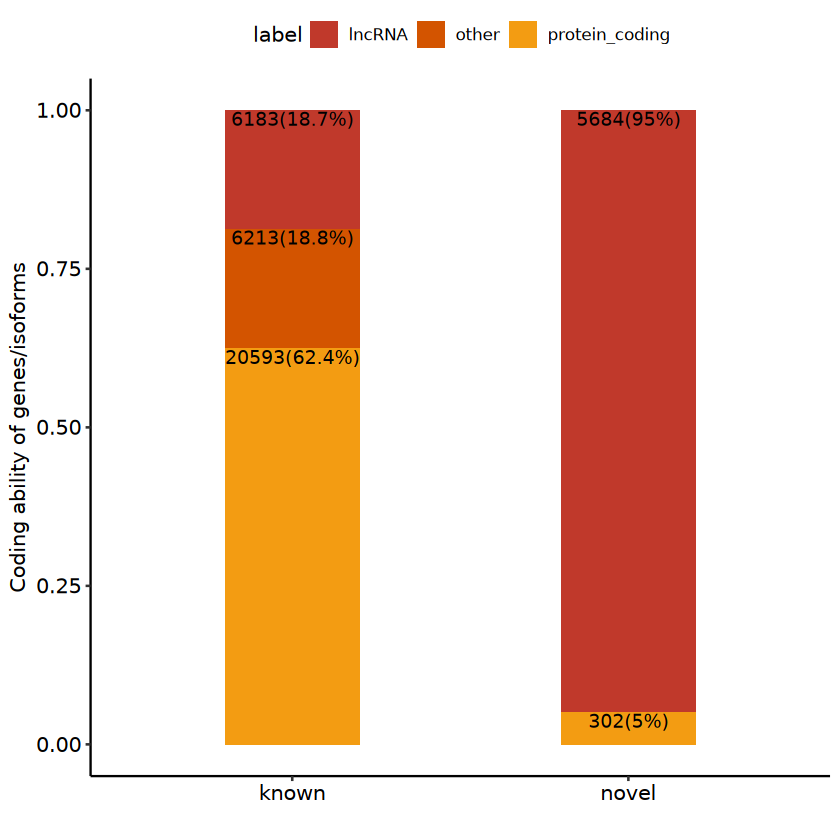

In [871]:
code.st$textlabel = paste0(code.st$counts,"(",round(code.st$prop,3)*100,"%)")
p1.0 = ggplot(code.st, aes(x = group,y = prop,fill = label)) +
geom_bar(stat = "identity",width = 0.4) +
geom_text(aes(label = textlabel),position = position_fill(),vjust = 1.1) +
scale_fill_flatui() +
theme_pubr() + xlab("") + ylab("Coding ability of genes/isoforms")
p1.0
ggexport(p1.0,filename = "result/figure5/coding_ability_statistic_24_05_01.pdf",width = 2.5,height = 3)

In [854]:
#fsrawdp = fsrawdp[fsrawdp$gene_id %in% gtff$gene_id,]
fsrawdp$codelabel = cpcdf[match(fsrawdp$gene_id,cpcdf$gene_id),]$label
fsrawdp$codegroup = cpcdf[match(fsrawdp$gene_id,cpcdf$gene_id),]$group

In [855]:
cpcread = fsrawdp[!is.na(fsrawdp$codelabel),]

In [856]:
#unique(cpcread$codelabel)
cpcread.st = cpcread %>% group_by(codegroup,codelabel) %>% summarise(readnum = length(unique(readid)))
cpcread.st

`summarise()` has grouped output by 'codegroup'. You can override using the
`.groups` argument.


codegroup codelabel      readnum 
1 known     lncRNA           847592
2 known     other           2173781
3 known     protein_coding 77151477
4 novel     lncRNA          6994738
5 novel     protein_coding    49501

codegroup codelabel      readnum  prop         textlabel
1 known     lncRNA           847592 0.0097181872 1%       
2 known     other           2173781 0.0249237968 2.5%     
3 known     protein_coding 77151477 0.8845912869 88.5%    
4 novel     lncRNA          6994738 0.0801991683 8%       
5 novel     protein_coding    49501 0.0005675608 0.1%

file saved to result/figure5/coding_ability_statistic_readlevel_24_05_01.pdf



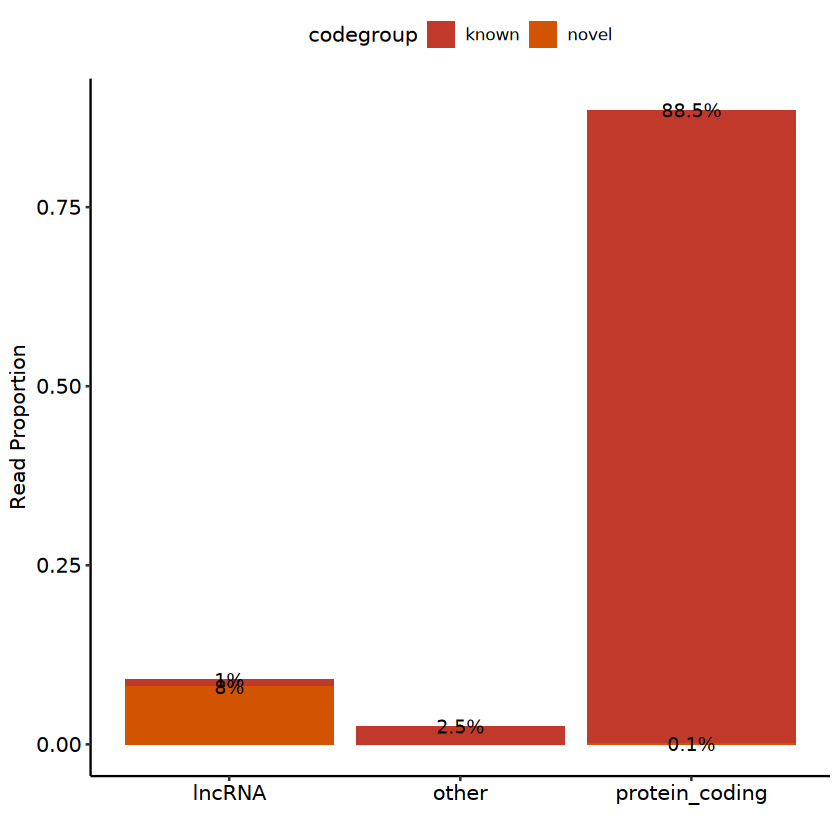

In [872]:
#cpcread.st2 = cpcread.st2 %>% group_by(codelabel) %>% summarise(readnum = sum(readnum))
#cpcread.st2
cpcread.st$prop = cpcread.st$readnum/sum(cpcread.st$readnum)
cpcread.st$textlabel = paste0(round(cpcread.st$prop,3)*100,"%")
cpcread.st
p1.1 = ggplot(cpcread.st,aes(x = codelabel,y = prop,fill = codegroup)) + geom_bar(stat = "identity") +
geom_bar(stat = "identity",width = 0.4) +
geom_text(aes(label = textlabel),position = position_stack(),vjust = 0.5) +
scale_fill_flatui() +
theme_pubr() + xlab("") + ylab("Read Proportion")
p1.1
ggexport(p1.1,filename = "result/figure5/coding_ability_statistic_readlevel_24_05_01.pdf",width = 2.5,height = 3)

#### Spatial coding ratio stat

In [858]:
ra = 500
cpcread$xid = as.integer(cpcread$x/(ra*2)) * ra * 2 + ra
cpcread$yid = as.integer(cpcread$y/(ra*2)) * ra * 2 + ra
cpcread$blockid = paste0(cpcread$xid,"_", cpcread$yid)

cpcread[is.na(cpcread$lobe),]$lobe = "none"
cpcclst.bl = cpcread %>% group_by(subcortical,lobe,blockid,codelabel) %>% 
    summarise(readnum = length(unique(readid)))
cpcclst.bl = cpcclst.bl %>% group_by(subcortical,lobe,blockid) %>% 
    mutate(readrate = readnum/sum(readnum))
#cpcclst.bl = cpcclst.bl[cpcclst.bl$codelabel == "noncoding",]


`summarise()` has grouped output by 'subcortical', 'lobe', 'blockid'. You can
override using the `.groups` argument.


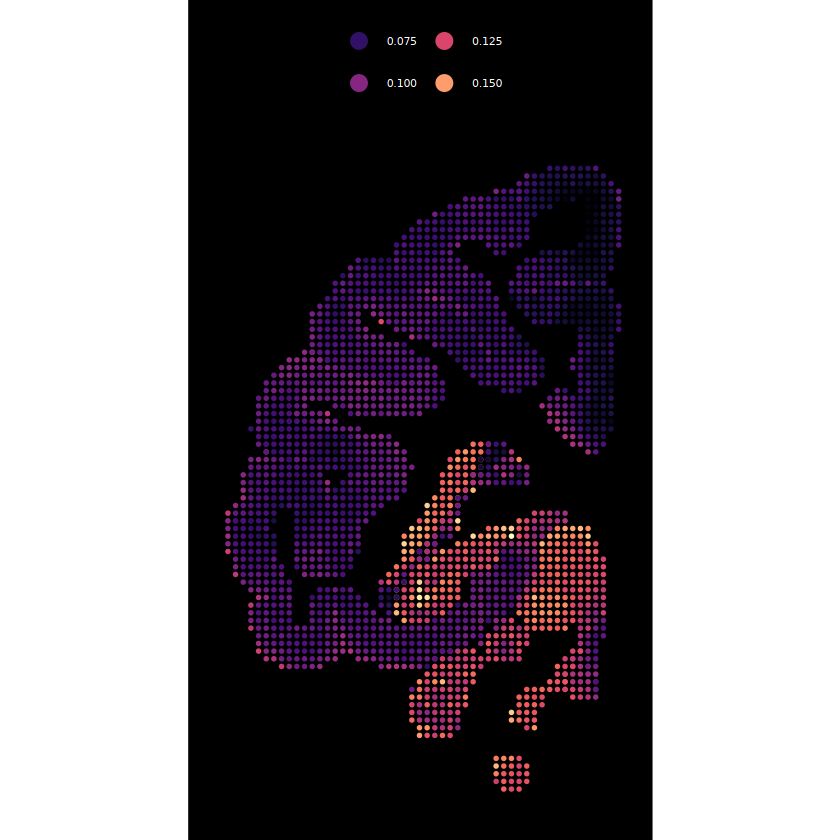

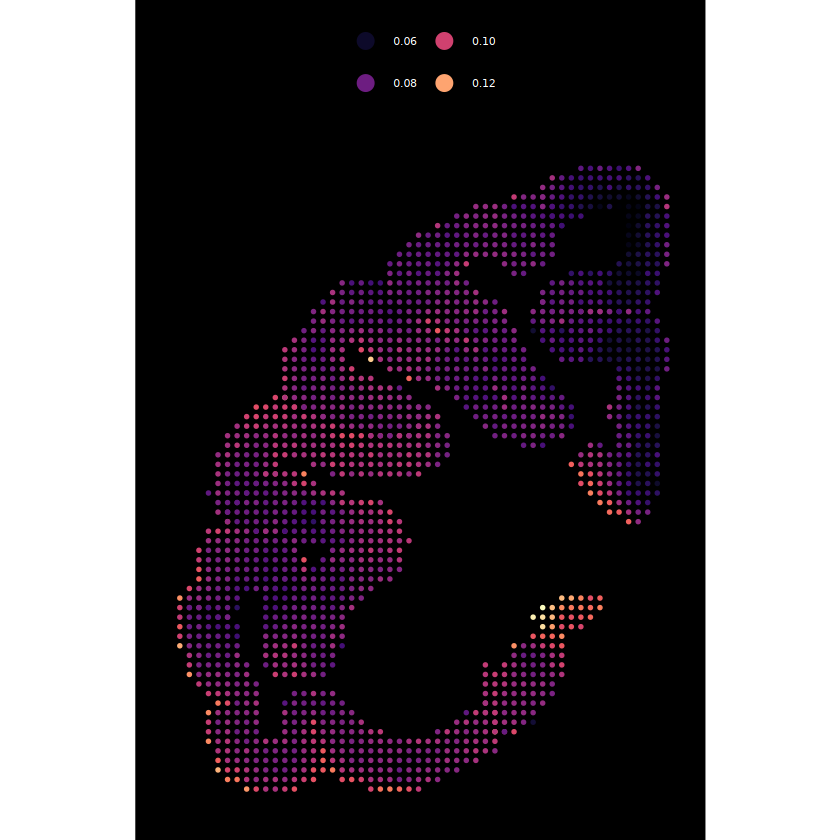

In [859]:
cpcclst.blf = cpcclst.bl[cpcclst.bl$codelabel == "lncRNA",]
cpcclst.blf$x = as.numeric(MySplit(cpcclst.blf$blockid,"_",1))
cpcclst.blf$y = as.numeric(MySplit(cpcclst.blf$blockid,"_",2))
cpcclst.blf = cpcclst.blf[cpcclst.blf$readnum > 100,]
pmkpti1 = ggplot(cpcclst.blf,aes(x = x, y = y,color = readrate)) +
      geom_point(size = 0.5) +
      theme_void() + 
      scale_color_viridis(option = "A") +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 6)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
        coord_fixed()
pmkpti1

pmkpti2 = ggplot(cpcclst.blf[cpcclst.blf$subcortical == "Cortex",],aes(x = x, y = y,color = readrate)) +
      geom_point(size = 0.5) +
      theme_void() + 
      scale_color_viridis(option = "A") +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 6)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
        coord_fixed()
pmkpti2


In [860]:
ggexport(pmkpti1,filename = "result/figure5/noncoding_ratio_block_spatial_stat_24_05_02.pdf",width = 4, height = 6)
ggexport(pmkpti2,filename = "result/figure5/noncoding_ratio_block_spatial_stat_cortex_24_05_02.pdf",width = 4, height = 6)

file saved to result/figure5/noncoding_ratio_block_spatial_stat_24_05_02.pdf

file saved to result/figure5/noncoding_ratio_block_spatial_stat_cortex_24_05_02.pdf



In [820]:
head(cpcclst.bl)

subcortical lobe blockid     codelabel      readnum readrate  
1 Cerebellum  none 15500_87500 lncRNA          745    0.12835975
2 Cerebellum  none 15500_87500 other           162    0.02791178
3 Cerebellum  none 15500_87500 protein_coding 4897    0.84372846
4 Cerebellum  none 15500_88500 lncRNA          743    0.13265488
5 Cerebellum  none 15500_88500 other           132    0.02356722
6 Cerebellum  none 15500_88500 protein_coding 4726    0.84377790

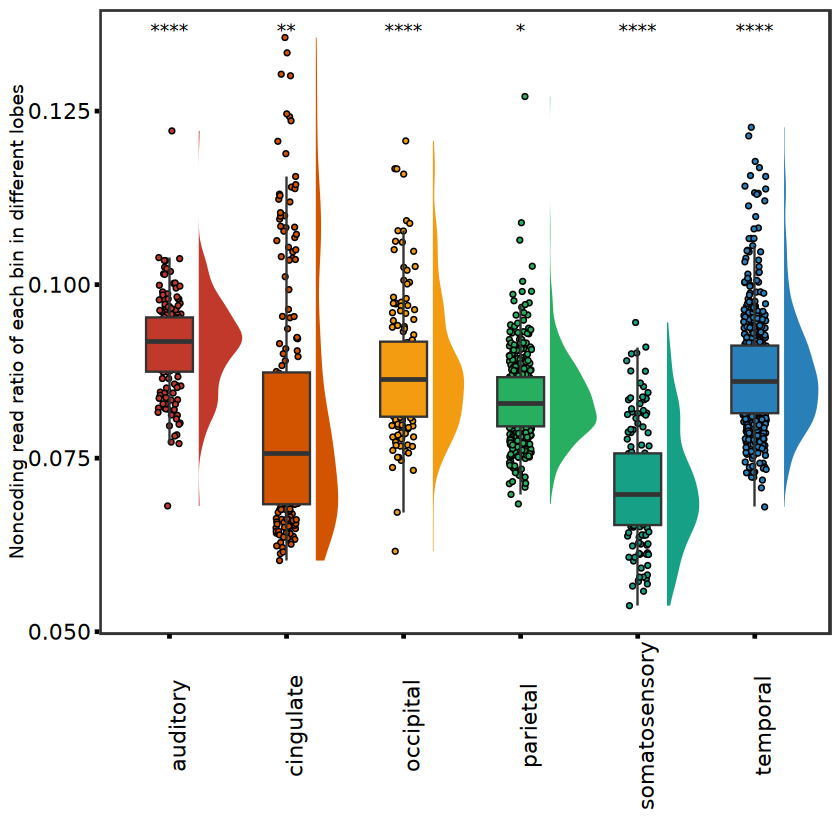

file saved to result/figure5/noncoding_ratio_block_spatial_stat_boxplot_24_05_01.pdf



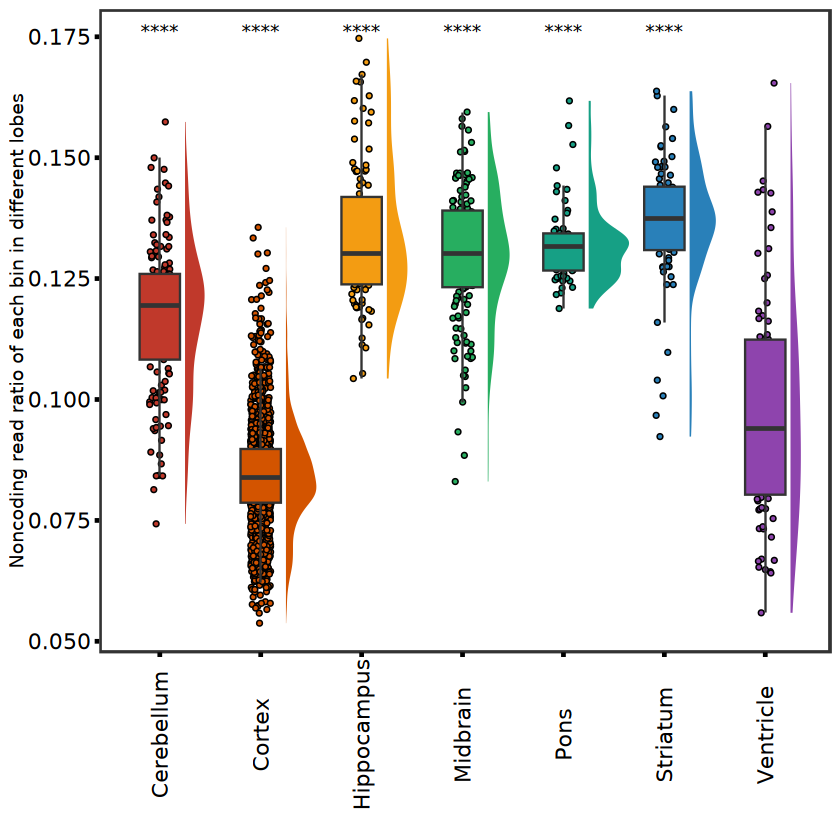

In [861]:
pcd1 = ggplot(cpcclst.blf[cpcclst.blf$lobe != "none",],aes(x = lobe,y = readrate,fill = lobe)) + 
      geom_jitter(aes(fill = lobe),shape=21,size=1,width=0.1) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color = NA) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        legend.position = "none",
        axis.ticks = element_line(color="black",linewidth = 1)) +
    scale_fill_flatui()+
    xlab("") + ylab("Noncoding read ratio of each bin in different lobes")
pcd1

pcd2 = ggplot(cpcclst.blf,aes(x = subcortical,y = readrate,fill = subcortical)) + 
      geom_jitter(aes(fill = subcortical),shape=21,size=1,width=0.1) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90,vjust = 0.5),
        axis.text.y = element_text(color = "black",size = 13),
        legend.position = "none",
        axis.ticks = element_line(color="black",linewidth = 1)) +
    scale_fill_flatui()+
    xlab("") + ylab("Noncoding read ratio of each bin in different lobes")
pcd2
ggexport(pcd1+pcd2,filename = "result/figure5/noncoding_ratio_block_spatial_stat_boxplot_24_05_01.pdf",width = 8,height = 5)

In [862]:
#cell type noncoding stat
cpcclst.cell = cpcread %>% group_by(lobe,class,subclass,codelabel) %>% 
    summarise(readnum = length(unique(readid)))
cpcclst.cell = cpcclst.cell %>% group_by(lobe,class,subclass) %>% 
    mutate(readrate = readnum/sum(readnum))
cpcclst.cell = cpcclst.cell[cpcclst.cell$class != "" & !is.na(cpcclst.cell$class) & cpcclst.cell$codelabel == "lncRNA",]
summary(cpcclst.cell$readnum)

`summarise()` has grouped output by 'lobe', 'class', 'subclass'. You can
override using the `.groups` argument.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2    2227    9489   18096   21723  133640 

In [823]:
cpcclst.cellf = cpcclst.cell[cpcclst.cell$readnum > 1000,]

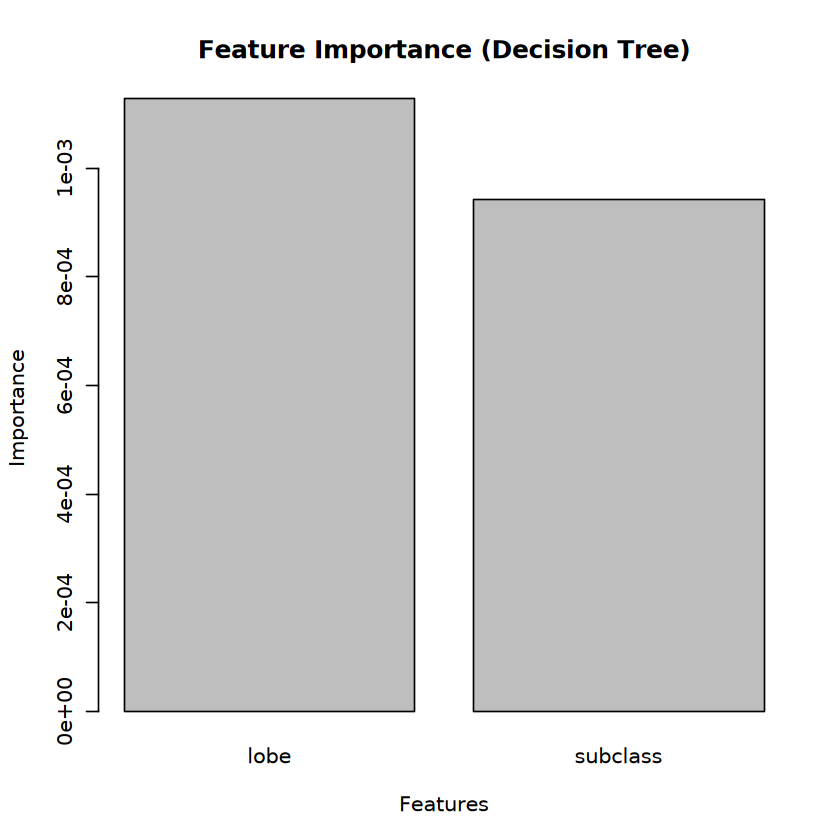

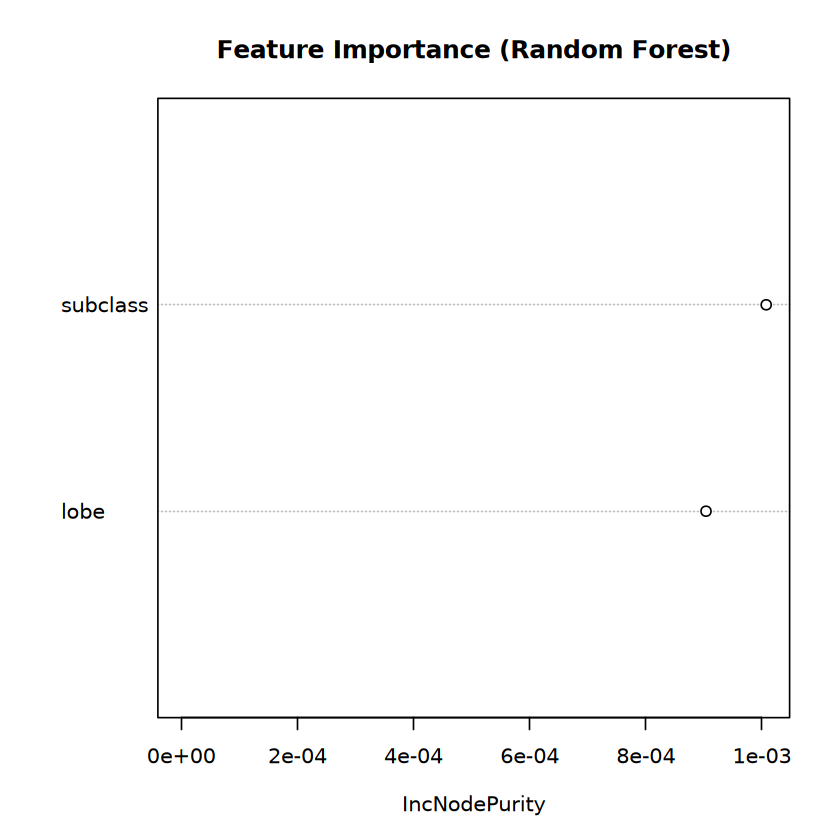

In [388]:
# 导入所需的包
library(rpart)
library(randomForest)

# 1. 准备数据集（假设你的数据框名为df，包含两个因素 factor1 和 factor2，以及数值变量 target）
# 例如：
# df <- data.frame(factor1 = factor(c("A", "B", "A", "B")),
#                  factor2 = factor(c("X", "Y", "Y", "X")),
#                  target = c(10, 15, 20, 25))

# 2. 拆分数据集为训练集和测试集（这里假设70%的数据用于训练，30%用于测试）
set.seed(123) # 设置随机种子以确保结果可复现
train_index <- sample(1:nrow(cpcclst.cellf), 0.7 * nrow(cpcclst.cellf))
train_data <- cpcclst.cellf[train_index, ]
test_data <- cpcclst.cellf[-train_index, ]

# 3. 构建决策树模型
tree_model <- rpart(readrate ~ subclass + lobe, data = train_data)

# 4. 查看特征重要性
# 获取特征重要性
tree_importance <- tree_model$variable.importance

# 5. 可视化特征重要性
barplot(tree_importance, main = "Feature Importance (Decision Tree)", xlab = "Features", ylab = "Importance")

# 6. 构建随机森林模型
rf_model <- randomForest(readrate ~ subclass + lobe, data = train_data)

# 7. 查看特征重要性
# 获取特征重要性
rf_importance <- importance(rf_model)

# 8. 可视化特征重要性
varImpPlot(rf_model, main = "Feature Importance (Random Forest)")


In [397]:
head(cpcclst.cellp)

lobe     class areatr codelabel readnum readrate  myclass group
1 auditory GABA  GABA   noncoding 1410    0.1493170 GABA    class
2 auditory GABA  GABA   noncoding 7439    0.1523199 GABA    class
3 auditory GABA  GABA   noncoding 2434    0.1502191 GABA    class
4 auditory GABA  GABA   noncoding 7737    0.1525704 GABA    class
5 auditory GABA  GABA   noncoding 1239    0.1584804 GABA    class
6 auditory GABA  GABA   noncoding 1880    0.1542754 GABA    class

Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `dplyr::mutate()`:
! Can't transform a data frame with duplicate names."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `dplyr::mutate()`:
! Can't transform a data frame with duplicate names."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `dplyr::mutate()`:
! Can't transform a data frame with duplicate names."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `dplyr::mutate()`:
! Can't transform a data frame with duplicate names."
file saved to result/figure5/subclass_lobe_noncoding_ratio_cmp_24_04_18.pdf



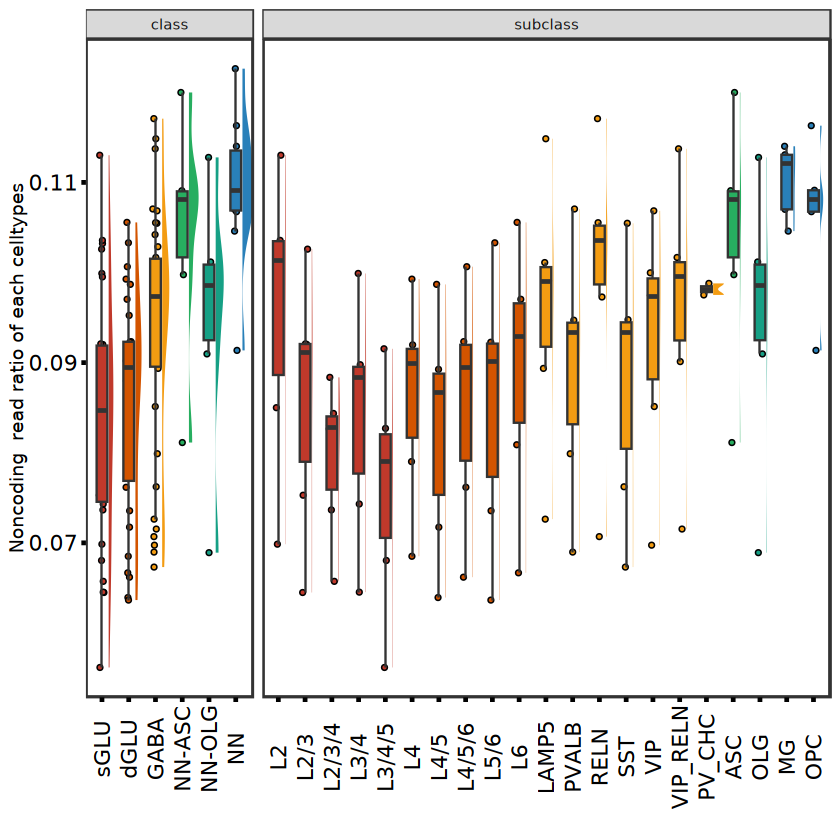

In [863]:
colnames(cpcclst.cellf)[3] = "areatr"
cpcclst.cellf$myclass = subclassan[match(cpcclst.cellf$areatr,subclassan$subclass),]$class
cpcclst.cellf$myclass = factor(cpcclst.cellf$myclass,levels = c("sGLU","dGLU","GABA","NN-ASC","NN-OLG","NN"))
cpcclst.cellp = cpcclst.cellf
cpcclst.cellp$areatr = cpcclst.cellp$myclass
cpcclst.cellp$group = "class"
cpcclst.cellf$group = "subclass"
cpcclst.cellp = rbind(cpcclst.cellp,cpcclst.cellf)
cpcclst.cellp = cpcclst.cellp %>% group_by(areatr) %>% filter(n() > 1)
cpcclst.cellp = cpcclst.cellp[order(cpcclst.cellp$myclass),]
cpcclst.cellp$areatr = factor(cpcclst.cellp$areatr,levels = unique(cpcclst.cellp$areatr))
pcd1 = ggplot(cpcclst.cellp,aes(x = areatr,y = readrate,fill = myclass)) +
      geom_jitter(aes(fill = myclass),shape=21,size=1,width=0.1) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
            facet_grid(~group,scale = "free",space = "free") +
      theme_bw()+
      theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90,vjust = 0.5),
        axis.text.y = element_text(color = "black",size = 13),
        legend.position = "none",
        axis.ticks = element_line(color="black",linewidth = 1)) +
    scale_fill_flatui()+
#    stat_compare_means(comparisons = list(c("GABA","NonNeuron"),c("GLU","NonNeuron"))) +
    xlab("") + ylab("Noncoding  read ratio of each celltypes")
pcd1
ggexport(pcd1,filename = "result/figure5/subclass_lobe_noncoding_ratio_cmp_24_04_18.pdf",width = 7,height = 5)

# pcd2 = ggplot(cpcclst.cellf,aes(x = lobe,y = readrate)) +
#     geom_boxplot() +
#     facet_grid(class~.,scales = "free") +
#     scale_color_viridis(option = "A") +
# #    stat_compare_means(comparisons = list(c("GABA","NonNeuron"),c("GLU","NonNeuron"))) +
#     xlab("") + ylab("Noncoding  read ratio of each subclass in different lobes")
# pcd2
# ggexport(pcd2,filename = "result/figure5/subclass_lobe_2_noncoding_ratio_cmp_24_04_18.pdf",width = 5,height = 15)

#### DTU and coding

In [826]:
#gtff[is.na(gtff$codelabel),]$codelabel = "none"
gtfdf = as.data.frame(gtf)
gtfdf = unique(gtfdf[,c("gene_id","transcript_id")])
cpcdf$gene_id = gtfdf[match(cpcdf$transcript_id,gtfdf$transcript_id),]$gene_id
genecst = cpcdf %>% group_by(gene_id) %>% summarise(labeln = length(unique(label)),label = label[1])
#genecst[genecst$labeln > 1,]$label = "Dual"
head(cpcdf)

Warning message:
"Unknown or uninitialised column: `transcript_id`."


ERROR: [1m[33mError[39m in `$<-`:[22m
[1m[22m[33m![39m Assigned data `value` must be compatible with existing data.
[31m✖[39m Existing data has 63710 rows.
[31m✖[39m Assigned data has 0 rows.
[36mℹ[39m Only vectors of size 1 are recycled.
[1mCaused by error in `vectbl_recycle_rhs_rows()`:[22m
[33m![39m Can't recycle input of size 0 to size 63710.


`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.
file saved to result/figure5/dtu_noncoding_ratio_stat_24_04_18.pdf



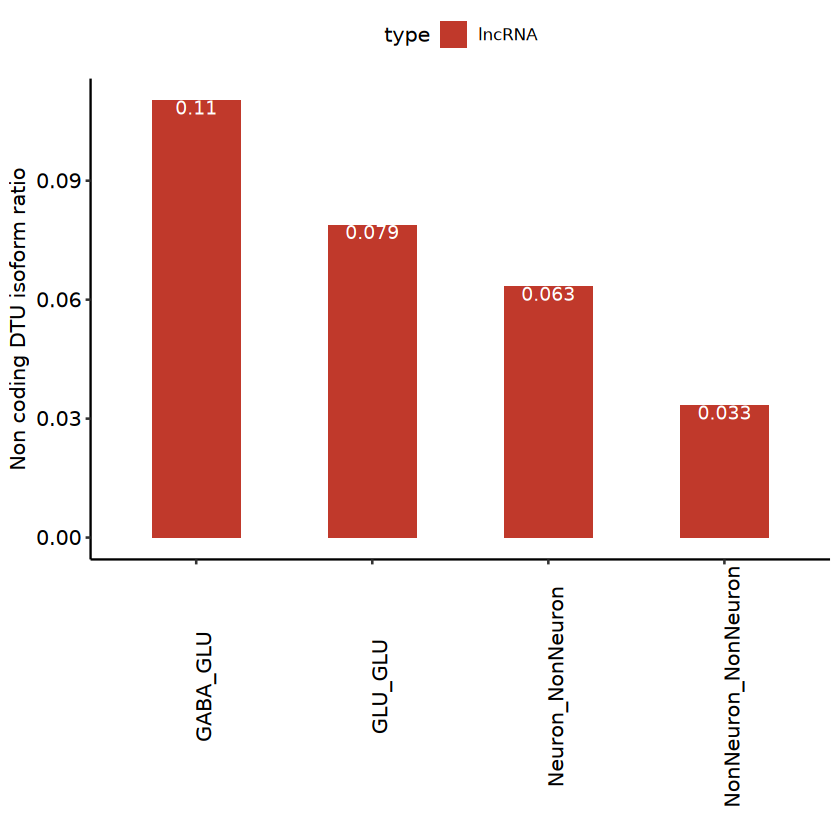

In [831]:
#  cpcdf[cpcdf$ID %in% c("BambuTx20710","XM_005568473.2"),]
  cpcst1 = NULL
  for (i in 1:length(isosigls.cl)) {
    isosigi = isosigls.cl[[i]]
    isosigi = isosigi[isosigi$sig != "N" & isosigi$sig != "Y",]
    cpcdfi = isosigi[isosigi$gene_id %in% cpcdf$gene_id,]
    nrow(cpcdfi)
    cpcdfi$type = cpcdf[match(cpcdfi$gene_id,cpcdf$gene_id),]$label
    cpcdfi$label = cpcdf[match(cpcdfi$gene_id,cpcdf$gene_id),]$label
    cpcsti = cpcdfi %>% group_by(label,type) %>% summarise(isonum = length(unique(gene_id)))
    cpcsti$isorate = cpcsti$isonum/sum(cpcsti$isonum)
    cpcsti$group = names(isosigls.cl)[i]
    cpcst1 = rbind(cpcst1,cpcsti)
  }
  # cpcst1$celltype = ""
  hubcmp = c("GABA_GLU","GLU_GLU","GABA_GABA",
             "Neuron_NonNeuron","NonNeuron_NonNeuron")
  cpcst1 = cpcst1[cpcst1$group %in% hubcmp,]
  p2.1 = ggplot(cpcst1[cpcst1$label == "lncRNA",],
         aes(x = group,y = isorate,fill = type)) + 
    geom_bar(stat = "identity",width = 0.5) + 
    geom_text(aes(label = round(isorate,3)),vjust = 1,color = "white",position = position_stack()) +  
    ylab("Non coding DTU isoform ratio") + xlab("") +
    scale_fill_flatui() +
    theme_pubr() + theme(axis.text.x = element_text(angle = 90))
  p2.1
ggexport(p2.1,filename = "result/figure5/dtu_noncoding_ratio_stat_24_04_18.pdf",width = 4,height = 5)

Warning message:
"Unknown or uninitialised column: `gene_id`."
`summarise()` has grouped output by 'label', 'areatr'. You can override using
the `.groups` argument.
file saved to result/figure5/dtu_noncoding_ratio_NN_stat_24_04_18.pdf



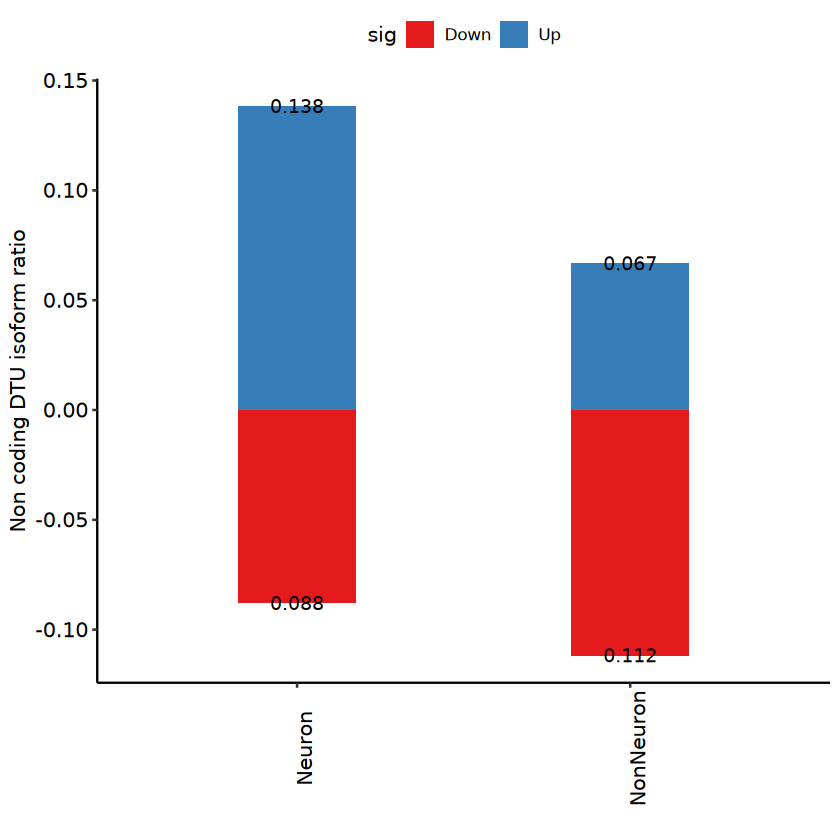

In [834]:
#analysis GLU_GLU dtu
isosigi = isosigls.cl$Neuron_NonNeuron
isosigi = isosigi[isosigi$sig != "N" & isosigi$sig != "Y",]
cpcdfi = merge(cpcdf,isosigi,by = "gene_id")
cpcdfi$type = genecst[match(cpcdfi$gene_id,genecst$gene_id),]$label
# cpcdfi = cpcdfi[cpcdfi$type == "Dual",]
# cpcdfi$dr = cpcdfi$relative - cpcdfi$meanrelative
# ggplot(cpcdfi,aes(x = areatr,y = dr,fill = label)) + geom_boxplot()

cpcsti = cpcdfi %>% group_by(label,areatr,sig) %>% summarise(isonum = length(unique(gene_id)))
cpcsti = cpcsti %>% group_by(areatr,sig) %>% mutate(isorate = isonum/sum(isonum))
cpcsti[cpcsti$sig == "Down",]$isorate = -cpcsti[cpcsti$sig == "Down",]$isorate

p2.3 = ggplot(cpcsti[cpcsti$label == "lncRNA",],
         aes(x = areatr,y = isorate,fill = sig)) + 
    geom_bar(stat = "identity",width = 0.7,position = position_dodge(0)) + 
    scale_fill_brewer(palette = "Set1") +
   # facet_grid(label~.,scales = "free") +
    geom_text(aes(label = abs(round(isorate,3))),position = position_dodge(0),color = "black") +  
    ylab("Non coding DTU isoform ratio") + xlab("") +
    theme_pubr() + theme(axis.text.x = element_text(angle = 90))
p2.3
ggexport(p2.3,filename = "result/figure5/dtu_noncoding_ratio_NN_stat_24_04_18.pdf",width = 2,height = 4)


In [656]:
isosigi = isosigls.cl$Neuron_NonNeuron
isosigi = isosigi[isosigi$sig != "N" & isosigi$sig != "Y",]
cpcdfi = merge(cpcdf,isosigi,by = "transcript_id")
cpcdfi$type = genecst[match(cpcdfi$gene_id.x,genecst$gene_id),]$label
cpcdfi = cpcdfi[cpcdfi$type == "Dual",]
p2.3 = ggplot(cpcdfi,aes(x = areatr, y = relative,fill = label)) + 
      geom_jitter(aes(fill = label),shape=21,size=1,width=0.1) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~label,scales = "free") +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = F,comparisons = list(c("Neuron","NonNeuron")))  +
      theme_bw()+
      theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90,vjust = 0.5),
        axis.text.y = element_text(color = "black",size = 13),
        legend.position = "none",
        axis.ticks = element_line(color="black",linewidth = 1)) +
    scale_fill_flatui()+
    xlab("") + ylab("Isoform ratio of DTUs between neuron and non-neuron cells")
ggexport(p2.3,filename = "result/figure5/dtu_noncoding_ratio_NN_boxplot_24_04_18.pdf",width = 4,height = 5)


file saved to result/figure5/dtu_noncoding_ratio_NN_boxplot_24_04_18.pdf



`summarise()` has grouped output by 'label', 'areatr', 'type'. You can override
using the `.groups` argument.
file saved to result/figure5/dtu_noncoding_ratio_subcortical_stat_24_04_18.pdf



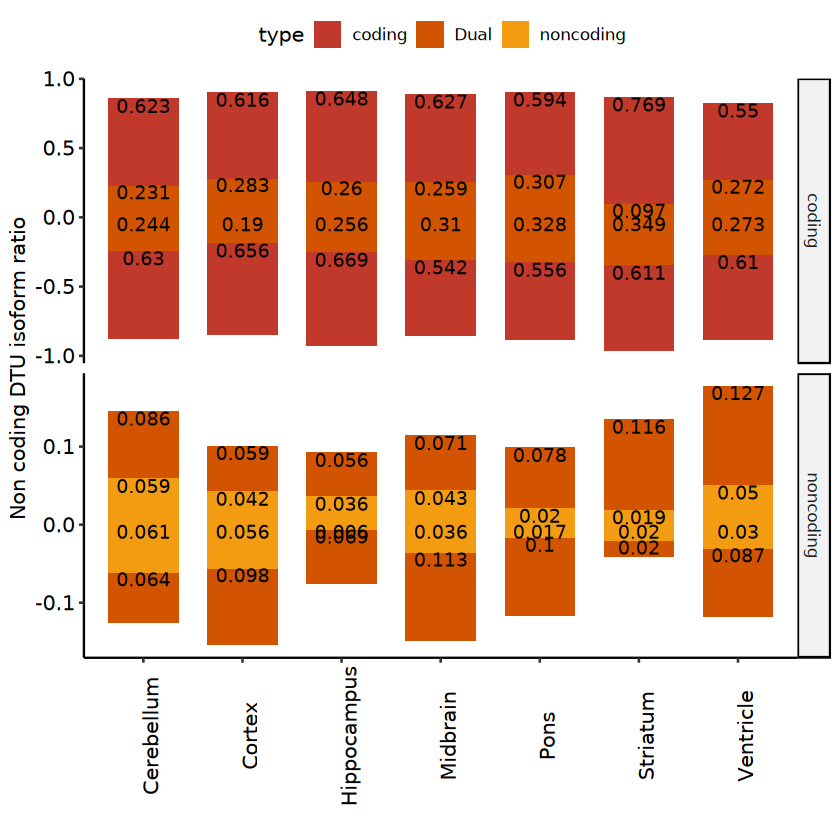

In [620]:
cpcst2 = NULL
isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig %in% c("Down","Up"),]
cpcdfi = merge(cpcdf,isosigi,by = "transcript_id")
cpcdfi$type = genecst[match(cpcdfi$gene_id.x,genecst$gene_id),]$label
cpcsti = cpcdfi %>% group_by(label,areatr,type,sig) %>% summarise(isonum = length(unique(transcript_id)))
cpcsti = cpcsti %>% group_by(areatr,sig) %>% mutate(isorate = isonum/sum(isonum))
cpcsti[cpcsti$sig == "Down",]$isorate = -cpcsti[cpcsti$sig == "Down",]$isorate


p2.2 = ggplot(cpcsti,
         aes(x = areatr,y = isorate,fill = type)) + 
    geom_bar(stat = "identity",width = 0.7,position = position_stack()) + 
    scale_fill_flatui() +
    facet_grid(label~.,scales = "free") +
    geom_text(aes(label = abs(round(isorate,3))),position = position_stack(),vjust = 1,color = "black") +  
    ylab("Non coding DTU isoform ratio") + xlab("") +
    theme_pubr() + theme(axis.text.x = element_text(angle = 90))
p2.2
ggexport(p2.2,filename = "result/figure5/dtu_noncoding_ratio_subcortical_stat_24_04_18.pdf",width = 4,height = 9)

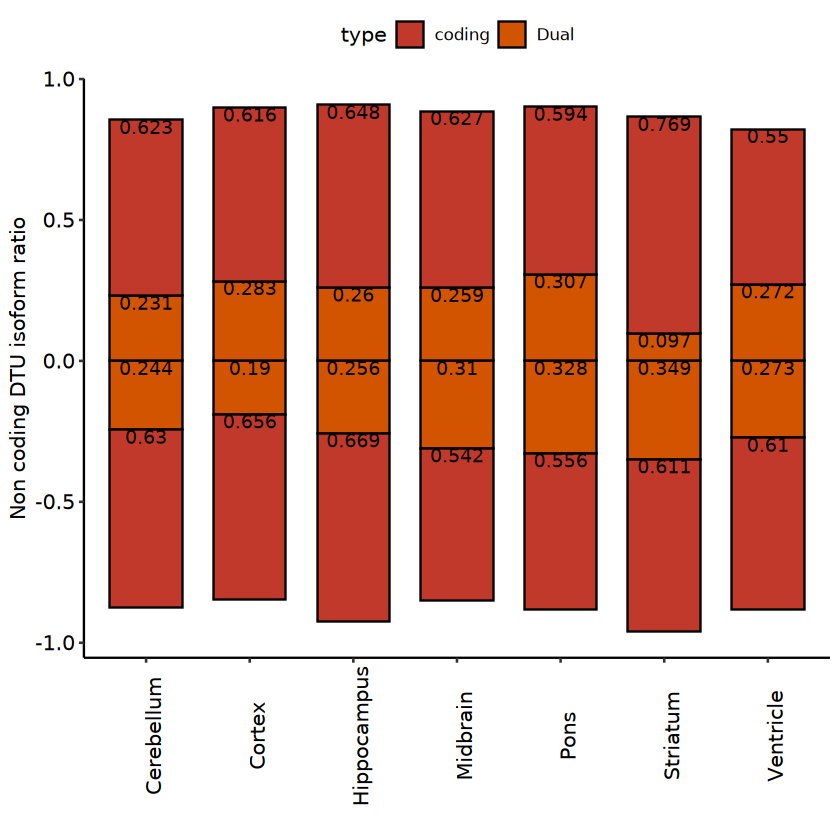

In [518]:
p2.3 = ggplot(cpcsti[cpcsti$label == "coding",],
         aes(x = areatr,y = isorate,fill = type)) + 
    geom_bar(stat = "identity",width = 0.7,position = position_stack(),color = "black") + 
    scale_fill_flatui() +
    geom_text(aes(label = abs(round(isorate,3))),position = position_stack(),vjust = 1,color = "black") +  
    ylab("Non coding DTU isoform ratio") + xlab("") +
    theme_pubr() + theme(axis.text.x = element_text(angle = 90))
p2.3
ggexport(p2.3,filename = "result/figure5/dtu_coding_ratio_subcortical_stat_24_04_18.pdf",width = 4,height = 5)

In [422]:
#go analysis of noncoding rna
unique(cpcsti$areatr)

[1] "Cerebellum"  "Cortex"      "Hippocampus" "Midbrain"    "Pons"       
[6] "Striatum"    "Ventricle"

#### GO Analaysis

In [660]:
library(gprofiler2)
MyGOPlot = function(hubgenei,ni,mytitle,mycolor = NULL){
    goi = gost(query = hubgenei,
               organism = "mmulatta")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(intersection_size) %>% 
    top_n(wt = intersection_size,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    if(is.null(mycolor)){
        mycolor = pal_flatui("default")(length(unique(godfi$source)))
    }
    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]
    if(nrow(godfi) > 0){
        pgi = ggplot(godfi,
               aes(x = intersection_size, y=term_name,fill = source)) + 
        geom_point(aes(size = gene_ratio),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank()) +
        ggtitle(mytitle)
    }
    return(pgi)
    
}

MyGOCal = function(hubgenei,ni){
    goi = gost(query = hubgenei,
               organism = "mmulatta")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(intersection_size) %>% 
    top_n(wt = intersection_size,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]

    return(godfi)
    
}


In [541]:
isosigi = isosigls.cl$GLU_GLU
isosigi = isosigi[isosigi$sig != "N" & isosigi$sig != "Y",]
cpcdfi = isosigi[isosigi$transcript_id %in% cpcdf$transcript_id,]
cpcdfi$label = cpcdf[match(cpcdfi$transcript_id,cpcdf$transcript_id),]$label

In [661]:
mycolor = pal_flatui("default")(5)
names(mycolor) = c("GO:BP","GO:MF","GO:CC","HP","KEGG")
hubgenei = unique(cpcdfi[cpcdfi$label == "noncoding",]$gene_id.x)
hubgenei
pgi = MyGOPlot(hubgenei,5,"Cortex",mycolor)
pgi
#ggexport(pgi,filename = "result/figure6_other_cmp/dtu_go_analysis_cluster6_cortex_high_24_04_17.pdf",width = 5,height = 6)

[1] "ATF7"           "BambuGene73265" "BambuGene98454" "CDC14B"        
 [5] "CMTM6"          "CNTFR"          "F3"             "FAM206A"       
 [9] "FAM89A"         "FRMD8"          "GATAD1"         "GCC1"          
[13] "GOLT1B"         "INVS"           "KIAA0355"       "KSR1"          
[17] "LIPE"           "LOC101866282"   "LOC102123757"   "LOC102130415"  
[21] "LOC102137500"   "LOC102137563"   "LOC102139028"   "LOC107128460"  
[25] "MARCH3"         "MED30"          "MORC2"          "NAA40"         
[29] "NEK11"          "ARPP19"         "PSME1_1"        "RBM3"          
[33] "PACRG"          "PAQR8"          "PTS"            "RBAK"          
[37] "RBCK1"          "SHISA2"         "SLC11A2"        "SLC35F3"       
[41] "SRSF5"          "TLN1"           "TMEM87A"        "UBAC1"         
[45] "UIMC1"          "WNT7A"          "MAP4"           "AKAP7"         
[49] "LOC102138187"   "FGF1"           "ZNF585A"        "CAMTA1"        
[53] "ZNF107"         "ZNF544"         "ZNF691"         "ZSCAN26"

[1] 0


ERROR: Error in MyGOPlot(hubgenei, 5, "Cortex", mycolor): object 'pgi' not found


#### Diger noncoding original

`summarise()` has grouped output by 'areatr', 'gene_id'. You can override using
the `.groups` argument.


[1] 4904

file saved to result/figure5/subcortical_noncoding_isoform_compare_readnorm_24_04_18.pdf



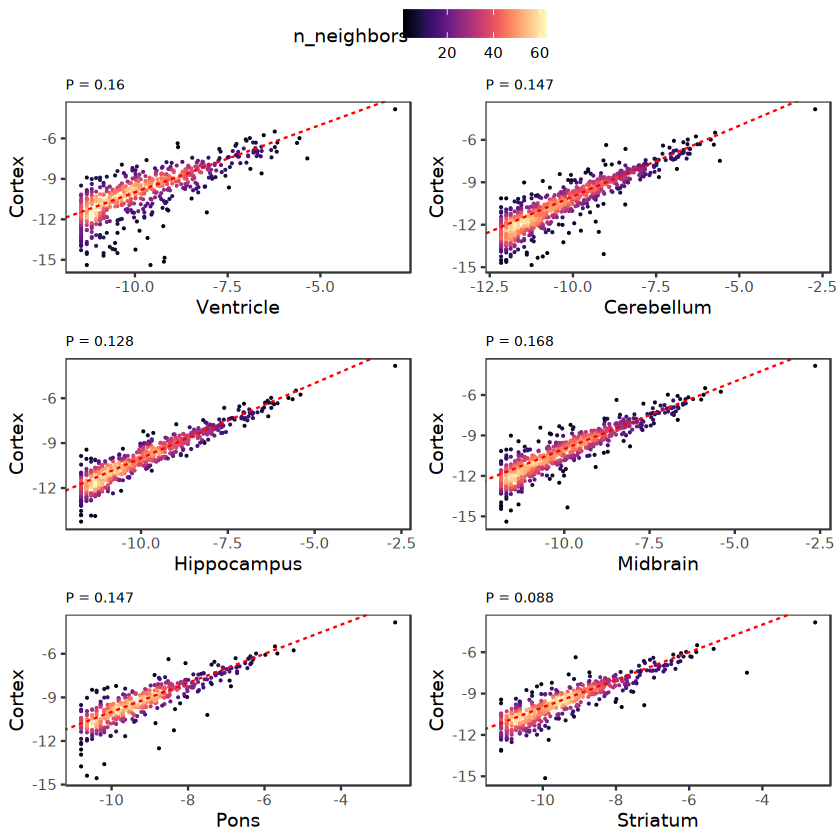

In [450]:
library(ggpointdensity)
cpcread$areatr = cpcread$subcortical
cpcread = cpcread %>% group_by(areatr) %>% mutate(readnumt = length(unique(readid)))
cpcread = cpcread %>% group_by(areatr,gene_id) %>% 
    mutate(genecount = length(unique(readid)),genenorm = genecount/readnumt)
cpcclst = cpcread %>% group_by(areatr,gene_id,codelabel) %>% 
    summarise(trancount = length(unique(readid)),rate = trancount/genecount[1],
           trannorm = trancount/readnumt[1],genenorm = genenorm[1])
cpcclstf1 = cpcclst %>% group_by(gene_id) %>% 
    filter(length(unique(codelabel)) == 1)
cpcclstf1 = cpcclstf1 %>% group_by(areatr,gene_id) %>% mutate(relativerate = trancount/sum(trancount))

cpcclstf1 = cpcclstf1[cpcclstf1$areatr != "",]
cpcclstf1 = cpcclstf1[!is.na(cpcclstf1$codelabel),]
#  qsave(cpcclst,file = "result/figure5/read_dedup_coding_st_24_04_16.qs")
#  cpcclst = qread("processed/isoform_downstream_analysis/read_dedup_coding_st_23_12_29.qs")
  
noncodeid = unique(cpcclstf1[cpcclstf1$codelabel == "noncoding",]$gene_id)
length(noncodeid)
  # cpcclst = cpcclst[cpcclst$gene_id %in% noncodeid,]
  
  #compare coding isoform expression
  # cpcclstf = cpcclst[cpcclst$codelabel == "noncoding",]
cpcclstf1 = cpcclstf1[cpcclstf1$trancount > 5,]
cpcclstfmx1 = dcast(cpcclstf1,gene_id+codelabel~areatr,
                     value.var = "trannorm",
                     fun.aggregate = sum)

  
PlotCodeNoncode = function(cpcclstfmx,mx,my,iscoding){
    cpcclstfmx = cpcclstfmx[rowSums(cpcclstfmx[,c(mx,my)] > 0) == 2,]
    cpcclstfmx$x = cpcclstfmx[,mx]
    cpcclstfmx$y = cpcclstfmx[,my]
    
    pval = t.test(cpcclstfmx[cpcclstfmx$codelabel == iscoding,mx],
           cpcclstfmx[cpcclstfmx$codelabel == iscoding,my],
           paired = T,alternative = "greater")$p.value
    
    p1.1 = ggplot(cpcclstfmx[cpcclstfmx$codelabel == iscoding,],
                  aes(x = log(x),y = log(y))) + 
      geom_pointdensity(size = 0.1) +
      geom_abline(intercept = 0, slope = 1, linetype = "dashed", 
                  color = "red") +
      scale_color_viridis(option = "A") +
      ggtitle(paste0("P = ",round(pval,3))) +
      xlab(mx) + ylab(my) + 
      theme_bw() + 
      theme(panel.grid = element_blank(),plot.title = element_text(size = 8))
    p1.1

   return(p1.1) 
}

comparls = list(c("Ventricle","Cortex"),c("Cerebellum","Cortex"),c("Hippocampus","Cortex"),c("Midbrain","Cortex"),
                c("Pons","Cortex"),c("Striatum","Cortex"))
plsi = list()
for(i in 1:length(comparls)){
    plsi[[i]] = PlotCodeNoncode(cpcclstfmx1,comparls[[i]][1],comparls[[i]][2],"noncoding")
}

p3.1 = ggarrange(plotlist = plsi,ncol = 2,nrow = 3,common.legend = T,legend = "top")
p3.1
ggexport(p3.1,filename = "result/figure5/subcortical_noncoding_isoform_compare_readnorm_24_04_18.pdf", width = 6,height = 9)

[1] 2340

file saved to result/figure5/subcortical_dualnoncoding_isoform_usage_compare_readnorm_24_04_18.pdf



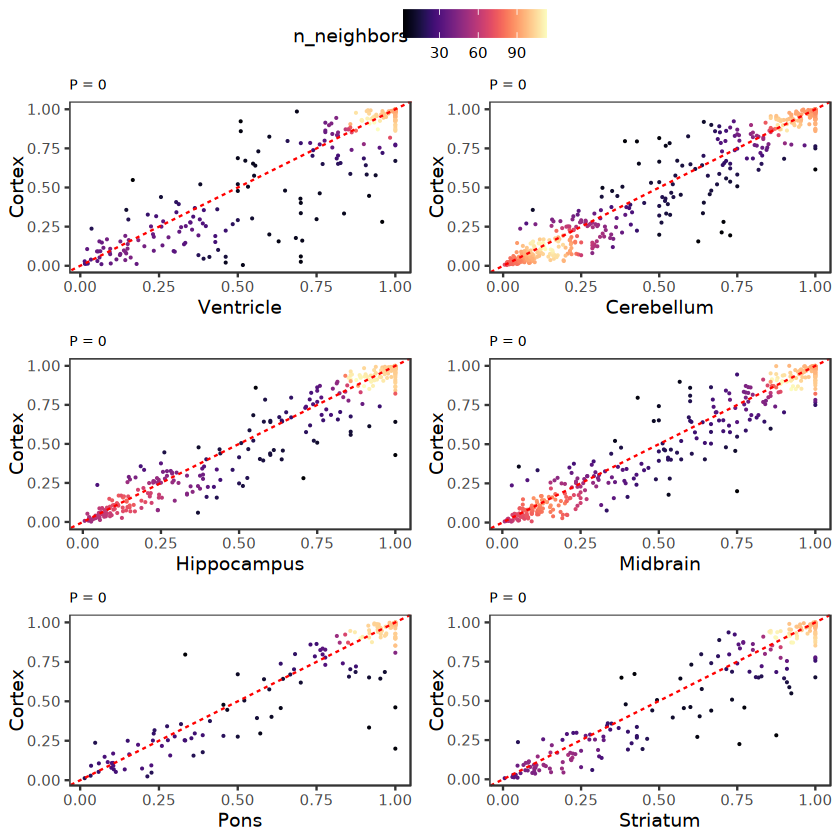

In [442]:
#compare gene noncoding isoform rate
cpcclstf2 = cpcclst %>% group_by(gene_id) %>% 
    filter(length(unique(codelabel)) > 1)
length(unique(cpcclstf2$gene_id))
cpcclstf2 = cpcclstf2[cpcclstf2$trancount > 5,]
cpcclstfmx2 = dcast(cpcclstf2,gene_id+codelabel~areatr,
                     value.var = "rate",
                     fun.aggregate = sum)
  
PlotCodeNoncode2 = function(cpcclstfmx,mx,my,iscoding){
    cpcclstfmx = cpcclstfmx[rowSums(cpcclstfmx[,c(mx,my)] > 0) == 2,]
    cpcclstfmx$x = cpcclstfmx[,mx]
    cpcclstfmx$y = cpcclstfmx[,my]
    
    pval = t.test(cpcclstfmx[cpcclstfmx$codelabel == iscoding,mx],
                  cpcclstfmx[cpcclstfmx$codelabel == iscoding,my],
                  paired = T,alternative = "greater")$p.value
    
    p1.1 = ggplot(cpcclstfmx[cpcclstfmx$codelabel == iscoding,],
                  aes(x = x,y = y)) + 
      geom_pointdensity(size = 0.1) +
      geom_abline(intercept = 0, slope = 1, linetype = "dashed", 
                  color = "red") +
      scale_color_viridis(option = "A") +
      ggtitle(paste0("P = ",round(pval,3))) +
      xlab(mx) + ylab(my) + 
      theme_bw() + 
      theme(panel.grid = element_blank(),plot.title = element_text(size = 8))
    p1.1
    
    return(p1.1) 
}

comparls = list(c("Ventricle","Cortex"),c("Cerebellum","Cortex"),c("Hippocampus","Cortex"),c("Midbrain","Cortex"),
                c("Pons","Cortex"),c("Striatum","Cortex"))
plsi = list()
for(i in 1:length(comparls)){
    plsi[[i]] = PlotCodeNoncode2(cpcclstfmx2,comparls[[i]][1],comparls[[i]][2],"noncoding")
}

p3.2 = ggarrange(plotlist = plsi,ncol = 2,nrow = 3,common.legend = T,legend = "top")
# p3.2 = annotate_figure(p3.2, top = text_grob("Noncoding isform normalized read",
#                                                face = "bold", 
#                                                size = 10))

p3.2
ggexport(p3.2,filename = "result/figure5/subcortical_dualnoncoding_isoform_usage_compare_readnorm_24_04_18.pdf", width = 6,height = 9)

  

In [455]:
qsave(list("ncdf1" = cpcclstfmx1,"ncdf2" = cpcclstfmx2),file = "result/figure5/subcortical_noncoding_isoform_compare_list.qs")

In [449]:
#compare noncoding gene and dual gene contribution
cpcread.st = cpcread %>% group_by(areatr) %>% summarise(readnumt = length(unique(readid)))
cpcclstf1.st = cpcclstf1[cpcclstf1$codelabel == "noncoding",] %>% group_by(areatr) %>% summarise(readnum1 = sum(trancount))
cpcclstf2.st = cpcclstf2[cpcclstf2$codelabel == "noncoding",] %>% group_by(areatr) %>% summarise(readnum2 = sum(trancount))
cpcread.st = merge(cpcread.st,cpcclstf1.st)
cpcread.st = merge(cpcread.st,cpcclstf2.st)
cpcread.st$readprop1 = cpcread.st$readnum1/cpcread.st$readnumt
cpcread.st$readprop2 = cpcread.st$readnum2/cpcread.st$readnumt
cpcread.st

areatr      readnumt readnum1 readnum2 readprop1 readprop2 
1 Cerebellum   1144464  193697   22777   0.1692469 0.01990189
2 Cortex      33735731 4256803  734991   0.1261808 0.02178672
3 Hippocampus   742715  130417   14111   0.1755949 0.01899921
4 Midbrain      842519  143242   16589   0.1700163 0.01968976
5 Pons          293469   51444    5346   0.1752962 0.01821657
6 Striatum      412957   81678    8110   0.1977881 0.01963885
7 Ventricle     564379   84518    9895   0.1497540 0.01753254

In [452]:
#cal gene only express in other region
cortexg = unique(cpcclstf1[cpcclstf1$areatr == "Cortex",]$gene_id)
cpcclstf1f = cpcclstf1[!cpcclstf1$gene_id %in% cortexg,]
cpcclstf1f.st = cpcclstf1f[cpcclstf1f$codelabel == "noncoding",] %>% group_by(areatr) %>% summarise(readnum3 = sum(trancount))
cpcread.st = merge(cpcread.st,cpcclstf1f.st)
cpcread.st$readprop3 = cpcread.st$readnum3/cpcread.st$readnumt
cpcread.st

areatr     readnumt readnum1 readnum2 readprop1 readprop2  readnum3
1 Cerebellum 1144464  193697   22777    0.1692469 0.01990189 104     
2 Striatum    412957   81678    8110    0.1977881 0.01963885  27     
3 Ventricle   564379   84518    9895    0.1497540 0.01753254  76     
  readprop3   
1 9.087223e-05
2 6.538211e-05
3 1.346613e-04

#### Plot DTU noncoding case

In [560]:
isosigi = isosigls$subcortical
isosighub = isosigi[isosigi$sig %in% c("Down","Up") & isosigi$gene_id %in% cpcclstfmx2$gene_id & isosigi$areatr == "Cortex",]
isosighub$label = cpcdf[match(isosighub$transcript_id,cpcdf$transcript_id),]$label
isosighub = isosighub[isosighub$label == "noncoding" & isosighub$sig == "Down" & isosighub$meanrelative > 0.3,]
length(unique(isosighub$gene_id))
unique(isosighub$gene_id)

[1] 40

[1] "ANKRD65"      "ARPP19"       "ARPP21"       "ATXN7L1"      "BRI3"        
 [6] "CAMTA1"       "CCDC85B"      "CLTA"         "CYSTM1"       "DCTN4"       
[11] "FAM183A"      "FAM229A"      "FIS1"         "HCFC1R1"      "LDOC1"       
[16] "LOC102123081" "LOC102126785" "LOC102131354" "LOC102134702" "LOC102139105"
[21] "LOC102147033" "LOC107126444" "LOC107127260" "LOC107128490" "LOC107129555"
[26] "MAL"          "MATN2"        "NKX6-2"       "NRXN2"        "PMM1"        
[31] "PPIA"         "RAB37"        "RPS20"        "SLC11A2"      "SNCB"        
[36] "SNRNP27"      "TDG"          "TMEM147"      "TMEM87A"      "YPEL3"

In [681]:
hubgenei = c("ATXN7L1","CAMTA1","FAM229A","MAL","NKX6-2","PMM1","PPIA","SLC11A2","TDG","HCFC1R1")

`summarise()` has grouped output by 'areatr', 'gene_id'. You can override using
the `.groups` argument.
file saved to result/figure5/nc_iso_switch_cases_subclass_plot_24_04_15.pdf



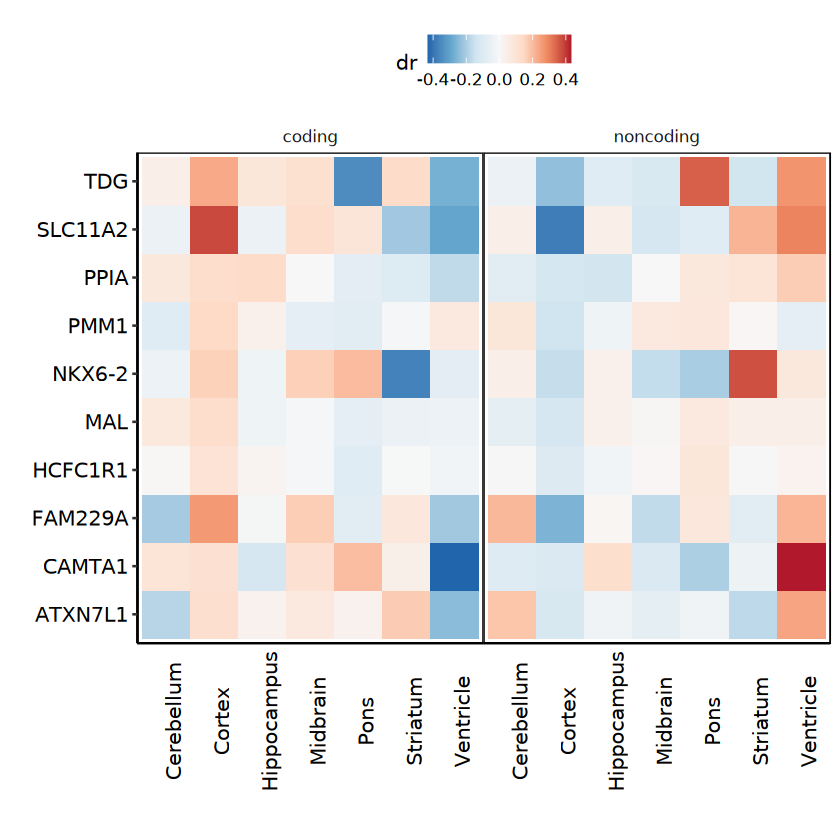

In [682]:
#plot ARPP21  
cpcread.case = cpcread[cpcread$gene_id %in% hubgenei,]
cpcread.case$areatr = cpcread.case$subcortical
cpcread.case = cpcread.case %>% group_by(areatr,gene_id) %>% 
    mutate(genecount = length(unique(readid)))
cpcread.case = cpcread.case %>% group_by(areatr,gene_id,codelabel) %>% 
    summarise(trancount = length(unique(readid)),rate = trancount/genecount[1])
cpcread.case = cpcread.case %>% group_by(gene_id,codelabel) %>% 
    mutate(meanrate = mean(rate))
cpcread.case$dr = cpcread.case$rate - cpcread.case$meanrate

pmd1cs = ggplot(cpcread.case,aes(x = areatr, y = gene_id, fill = dr)) + 
    geom_tile() +
    scale_color_viridis(option = "A") +
    scale_fill_distiller(palette = "RdBu") +
    facet_grid(~codelabel,space = "free") + 
    scale_size_continuous(range = c(0.1,5)) +
    theme_pubr() + 
    theme(axis.text.x = element_text(angle = 90),
      axis.ticks.x = element_blank(),
      strip.background = element_rect(fill = NA,color = NA),
      panel.spacing = unit(0,'lines'),
     panel.border = element_rect(fill = NA)) +
    coord_fixed() + xlab("") + ylab("")
pmd1cs
ggexport(pmd1cs,filename = "result/figure5/nc_iso_switch_cases_subclass_plot_24_04_15.pdf",width = 8,height = 6)


In [663]:
fsrawdp.cellb = qread(file = "data/reads_full_anotation/longread_cell_position_with_subcortical_24_03_29.qs")
fsrawdp.cell = qread(file = "data/reads_full_anotation/longread_cell_isoform_with_subcortical_24_03_29.qs")

In [667]:
fsrawdp.cell$label = cpcdf[match(fsrawdp.cell$transcript_id,cpcdf$transcript_id),]$label
fsrawdp.cell$transcript_id = paste0(fsrawdp.cell$label,"-",fsrawdp.cell$transcript_id)
head(fsrawdp.cell)

x    y     gene_id transcript_id         subcortical readnum label 
1 3361 32286 MGP     coding-XM_005570218.2 Cortex      2       coding
2 3361 32379 RPL26L1 coding-XM_005558537.2 Cortex      1       coding
3 3361 32460 RPLP0   coding-NM_001283935.1 Cortex      1       coding
4 3361 32516 ABCB9   coding-XM_015431731.1 Cortex      1       coding
5 3361 32558 PTGDS   coding-NM_001285069.1 Cortex      1       coding
6 3361 32568 SPARCL1 coding-XM_005555374.2 Cortex      1       coding

In [672]:
gtfc = gtf
gtfc$label = cpcdf[match(gtfc$transcript_id,cpcdf$transcript_id),]$label
gtfc$transcript_id = paste0(gtfc$label,"-",gtfc$transcript_id)

noncoding-HCFC1R1-WeiLab-1    coding-HCFC1R1-WeiLab-2 
                 "#D79BA9"                  "#B2DD73" 
     coding-XM_005591029.1   noncoding-XM_005591031.1 
                 "#A2D4CC"                  "#B367D8"

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 506 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 283 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 189 rows containing missing values or values outside the scale range
(`geom_segment()`)."


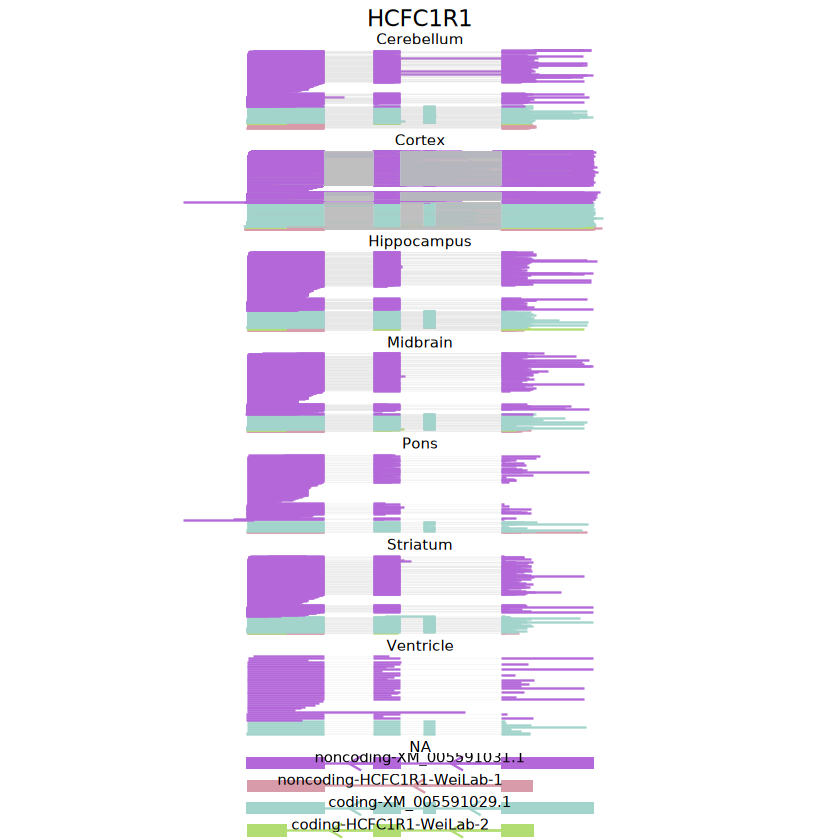

Warning message:
"Removed 506 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 283 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 189 rows containing missing values or values outside the scale range
(`geom_segment()`)."
file saved to result/figure5/nc_case_read_splice_plot_HCFC1R1_24_04_18.pdf

file saved to result/figure5/nc_case_read_spatial_plot_HCFC1R1_24_04_18.pdf



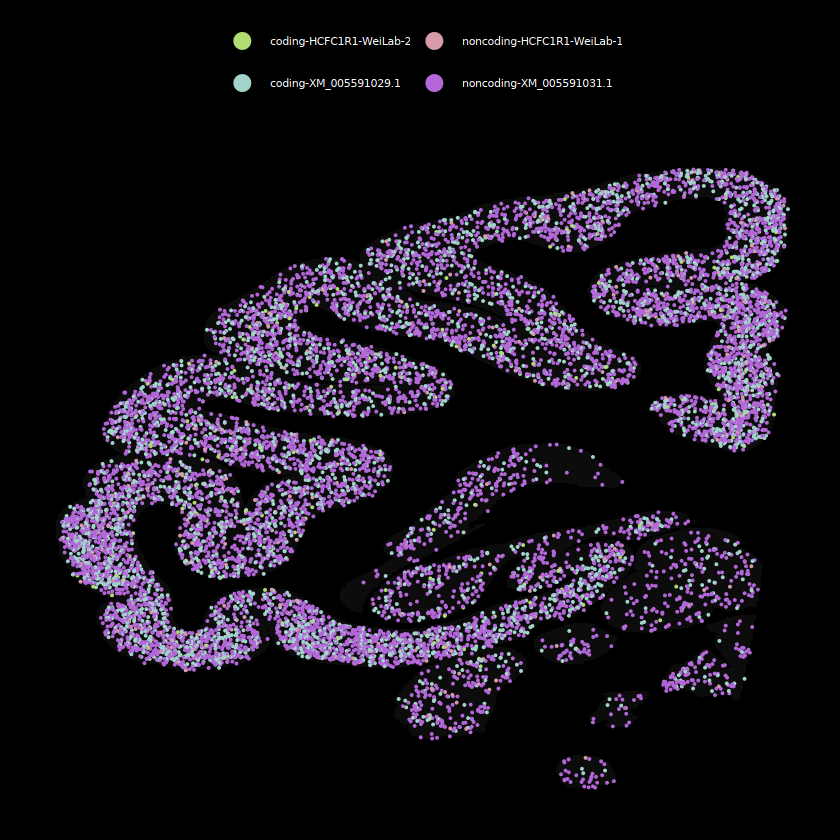

In [691]:
#case piont and transcript plot
geneex = "HCFC1R1"
cpcread$areatr = cpcread$subcortical
grtdfl = BuildPlotBed(cpcread,longbed,'areatr',geneex,NULL)
grtdfl$label = cpcdf[match(grtdfl$transcript_id,cpcdf$transcript_id),]$label
grtdfl$transcript_id = paste0(grtdfl$label,"-",grtdfl$transcript_id)

#grtdfl = grtdfl[grtdfl$transcript_id %in% hubtrans,]
mycolors = distinctColorPalette(length(unique(grtdfl$transcript_id)))
names(mycolors) = unique(grtdfl$transcript_id)
mycolors
pci1 = IsoformReadPlot(gtfc, grtdfl, geneex,onlyhub = F,mycolors)
pci1

pci2 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,NULL,mycolors,NULL)
pci2
ggexport(pci1,filename = "result/figure5/nc_case_read_splice_plot_HCFC1R1_24_04_18.pdf",width = 5,height = 6)
ggexport(pci2,filename = "result/figure5/nc_case_read_spatial_plot_HCFC1R1_24_04_18.pdf",width = 4,height = 6)

noncoding-TLN1-WeiLab-1   coding-XM_005581352.2   coding-XM_005581354.2 
              "#BD69CD"               "#C0BCC0"               "#ACDE84"

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 24 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 14 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 7 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."


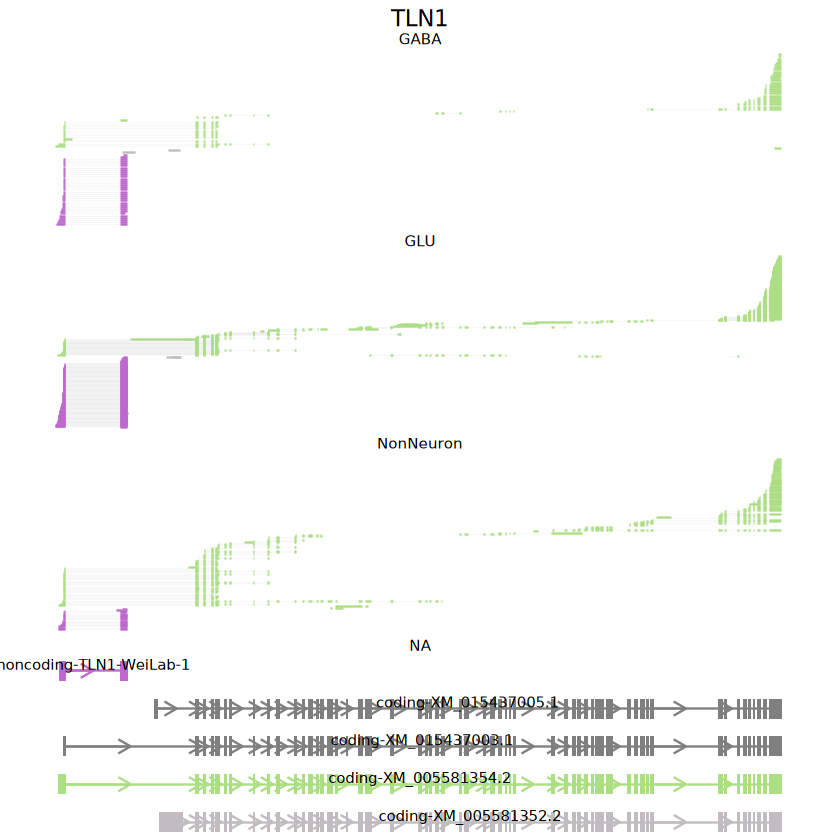

Warning message:
"Removed 24 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 14 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 7 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."
file saved to result/figure5/nc_case_read_splice_plot_TLN1_24_04_18.pdf

file saved to result/figure5/nc_case_read_spatial_plot_TLN1_24_04_18.pdf



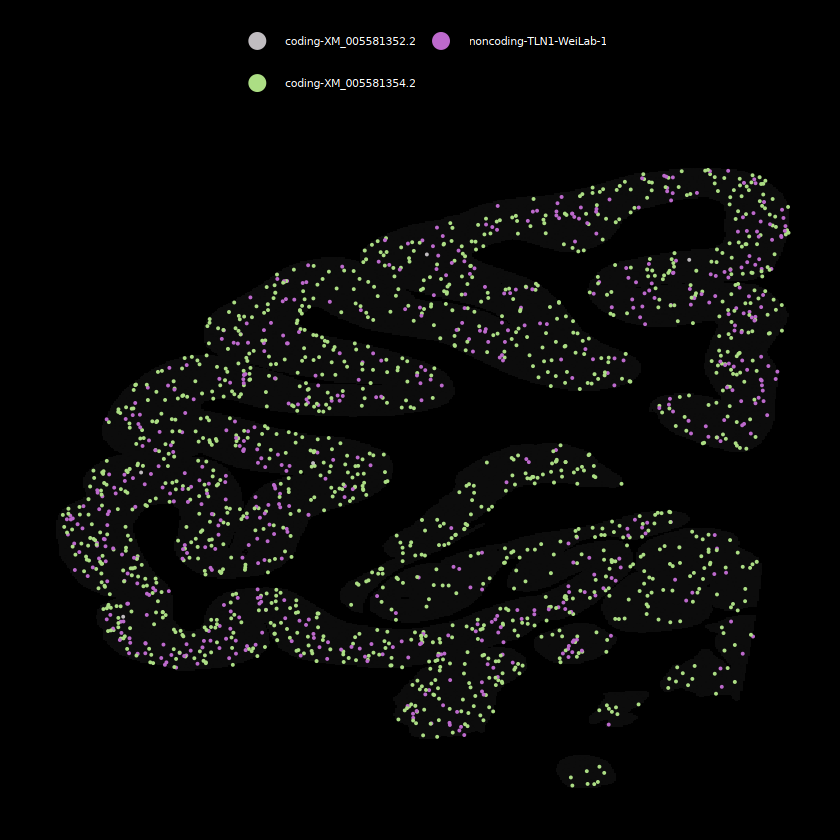

In [689]:
#case piont and transcript plot
geneex = "TLN1"
cpcread$areatr = cpcread$class
grtdfl = BuildPlotBed(cpcread,longbed,'areatr',geneex,NULL)
grtdfl$label = cpcdf[match(grtdfl$transcript_id,cpcdf$transcript_id),]$label
grtdfl$transcript_id = paste0(grtdfl$label,"-",grtdfl$transcript_id)

#grtdfl = grtdfl[grtdfl$transcript_id %in% hubtrans,]
mycolors = distinctColorPalette(length(unique(grtdfl$transcript_id)))
names(mycolors) = unique(grtdfl$transcript_id)
mycolors
pci1 = IsoformReadPlot(gtfc, grtdfl, geneex,onlyhub = F,mycolors)
pci1

pci2 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,NULL,mycolors,NULL)
pci2
ggexport(pci1,filename = "result/figure5/nc_case_read_splice_plot_TLN1_24_04_18.pdf",width = 5,height = 6)
ggexport(pci2,filename = "result/figure5/nc_case_read_spatial_plot_TLN1_24_04_18.pdf",width = 4,height = 6)

In [ ]:
length(unique(fsrawdp$readid))

### GO function analysis

In [6]:
install.packages("gprofiler2")
library(gprofiler2)

Installing package into '/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library'
(as 'lib' is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [131]:
#hubgene select and divid
mdls = qread("result/figure4/module_hub_gene_list_24_04_16.qs")
head(mdls$md1)
mdcell = read.csv("result/figure3/sigiso_subclass_transcript_dr_cluster_tab.csv")
mdc1 = unique(mdcell[mdcell$cluster == 1,]$gene_id)
length(mdc1)

gene_id transcript_id  ms        md        dr          counts countd
1 AAAS    AAAS-WeiLab-1  0.9230268 0.9045414  0.01848537 302    234   
2 AAAS    AAAS-WeiLab-2  0.9370820 0.8944723  0.04260973 316    230   
3 AAAS    XM_005571000.2 0.9354646 0.9011507  0.03431394 312    234   
4 AAAS    XM_005571001.1 0.9354646 0.8915222  0.04394245 312    231   
5 AAAS    XM_015430971.1 0.8992173 0.8906408  0.00857644 300    229   
6 AAAS    XM_015430972.1 0.4893846 0.5248370 -0.03545237 170    130   
  pvalue    padj
1 0.6356718 1   
2 0.2352177 1   
3 0.4741134 1   
4 0.3251095 1   
5 0.8106097 1   
6 0.6014148 1

[1] 101

[1] 111

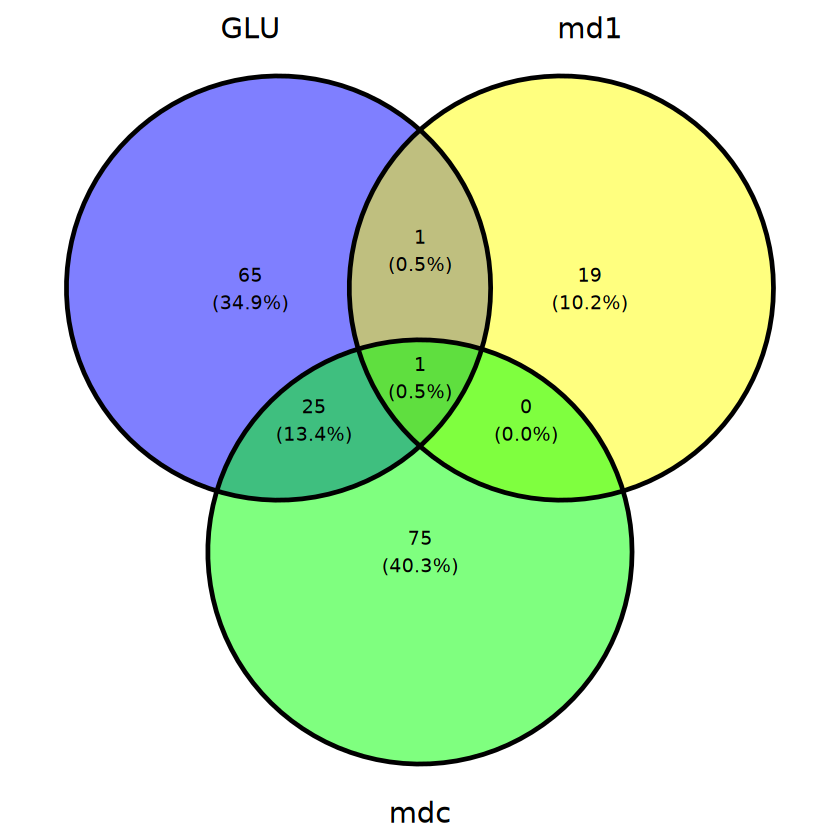

In [137]:
isosigi = isosigls.cl$GLU_GLU
glug = unique(isosigi[isosigi$sig != "N",]$gene_id)
mdg = unique(mdls$md1[mdls$md1$pvalue < 0.01 & abs(mdls$md1$dr) > 0.1,]$gene_id)
#library(ggvenn)
hubgene = unique(c(glug,mdg))
#intersect(glug,unique(mdls$md1$gene_id))
ggvenn(list("GLU" = glug,"md1" = mdg,"mdc" = mdc1))
#hubgene = glug
length(hubgene)

In [65]:
CalOddRate = function(godf,n){
    intersectsize = godf$intersection_size
    querysize = godf$query_size
    termsize = godf$term_size
    a = intersectsize
    b = querysize - intersectsize
    c = termsize - intersectsize
    d = 30000 - termsize - querysize + intersectsize
    godf$odds_ratio = (a*d)/(b*c)
    godf = godf[godf$p_value < 0.05,]
    godf = godf %>% group_by(source) %>% arrange(desc(odds_ratio))%>%
      top_n(n)
    return(godf)
}



query   significant p_value      term_size query_size intersection_size
1 query_1 TRUE        5.207342e-05 9202      64         50               
2 query_1 TRUE        3.919450e-02 1262      64         13               
3 query_1 TRUE        2.122347e-02  863      64         11               
4 query_1 TRUE        3.271671e-02  353      64          7               
5 query_1 TRUE        3.047916e-02  360      41          8               
6 query_1 TRUE        2.741342e-02  267      41          7               
  precision recall      term_id    source term_name                    
1 0.7812500 0.005433601 GO:0005737 GO:CC  cytoplasm                    
2 0.2031250 0.010301109 GO:0005739 GO:CC  mitochondrion                
3 0.1718750 0.012746234 GO:0045202 GO:CC  synapse                      
4 0.1093750 0.019830028 GO:0098794 GO:CC  postsynapse                  
5 0.1951220 0.022222222 KEGG:05014 KEGG   Amyotrophic lateral sclerosis
6 0.1707317 0.026217228 KEGG:05020 KEGG   Prion disease                
  effective_domain_size source_order parents      gene_ratio 
1 19785                  309         GO:00056.... 0.005433601
2 19785                  310         GO:00057.... 0.010301109
3 19785                 2140           GO:0030054 0.012746234
4 19785                 3257         GO:00452.... 0.019830028
5  8007                  413           KEGG:00000 0.022222222
6  8007                  416           KEGG:00000 0.026217228

file saved to result/figure5/GO_analysis_GLU_dtu_24_04_16.pdf



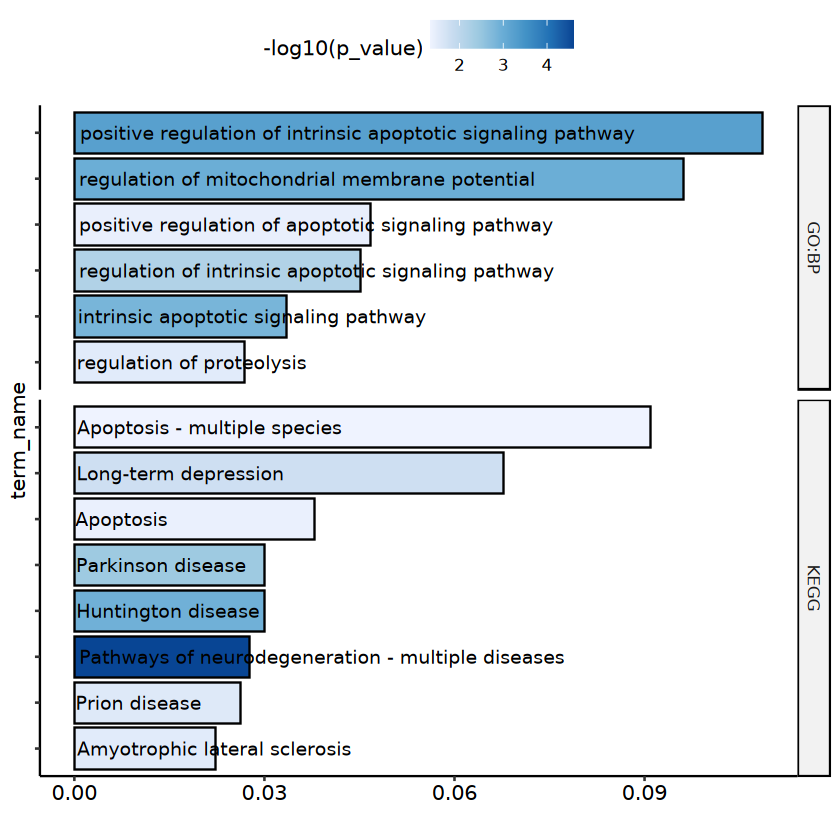

In [179]:
goi = gost(query = glug,
               organism = "mmulatta")
#godfi = CalOddRate(goi$result,5)
godfi = goi$result
godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(gene_ratio) %>% top_n(wt = gene_ratio,n = 10)
godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
head(godfi)
p6b = ggplot(godfi[godfi$source != "GO:CC",],
               aes(x = gene_ratio, y=term_name,fill = -log10(p_value))) + 
    geom_bar(stat = "identity",color = "black") +
    geom_text(aes(label = term_name,x = 0),color = "black",hjust = -0.01) +
    scale_color_flatui() +
    scale_fill_distiller(direction = 1) +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    facet_grid(source~.,scales = "free",space = "free") + 
    xlab("") +
    theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank())
p6b
ggexport(p6b,filename = "result/figure5/GO_analysis_GLU_dtu_24_04_16.pdf",width = 6,height = 5)

In [ ]:
goi = gost(query = glug,
               organism = "mmulatta")
godfi = goi$result
godfi$gene_ratio = godfi$intersection_size/godfi$term_size
godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(gene_ratio) %>% top_n(wt = gene_ratio,n = 10)
godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
head(godfi)
p6b = ggplot(godfi[godfi$source != "GO:CC",],
               aes(x = gene_ratio, y=term_name,fill = -log10(p_value))) + 
    geom_bar(stat = "identity",color = "black") +
    geom_text(aes(label = term_name,x = 0),color = "black",hjust = -0.01) +
    scale_color_flatui() +
    scale_fill_distiller(direction = 1) +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    facet_grid(source~.,scales = "free",space = "free") + 
    xlab("") +
    theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank())
p6b

[1] 364

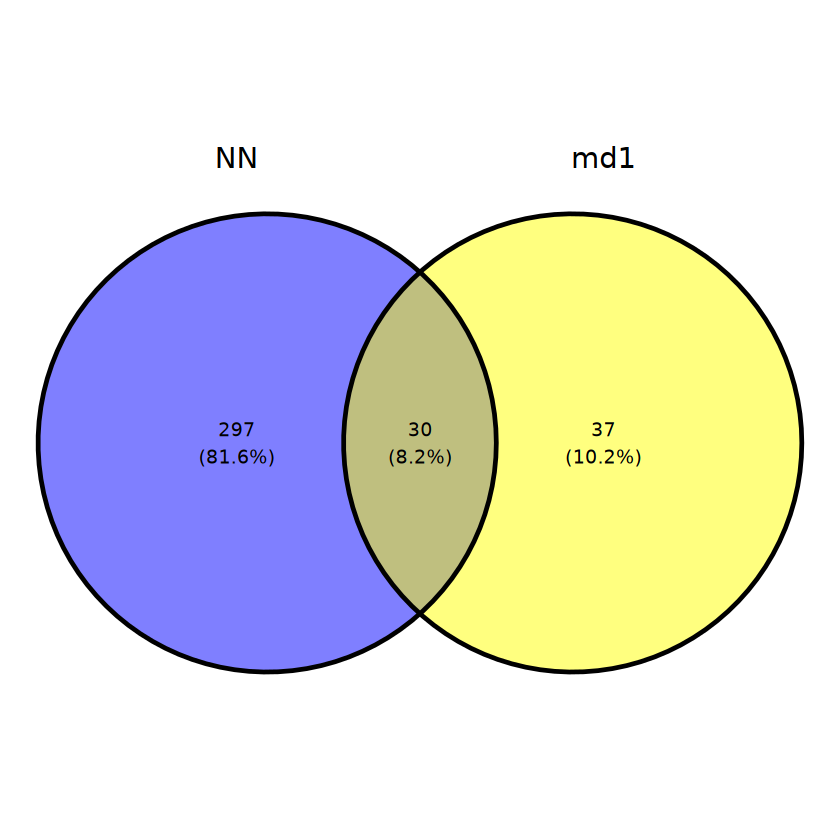

In [162]:
isosigi = isosigls.cl$Neuron_NonNeuron
mdg2 = unique(mdls$md2[mdls$md2$pvalue < 0.05 & abs(mdls$md2$dr) > 0.1,]$gene_id)
nng = unique(isosigi[isosigi$sig != "N" & isosigi$sig != "Y",]$gene_id)

isosigi = isosigls$layer
l1g = unique(isosigi[isosigi$sig == "Up" & isosigi$areatr == "l1",]$gene_id)
hubgene2 = unique(c(nng,l1g))
length(hubgene2)
ggvenn(list("NN" = nng,"md1" = l1g))

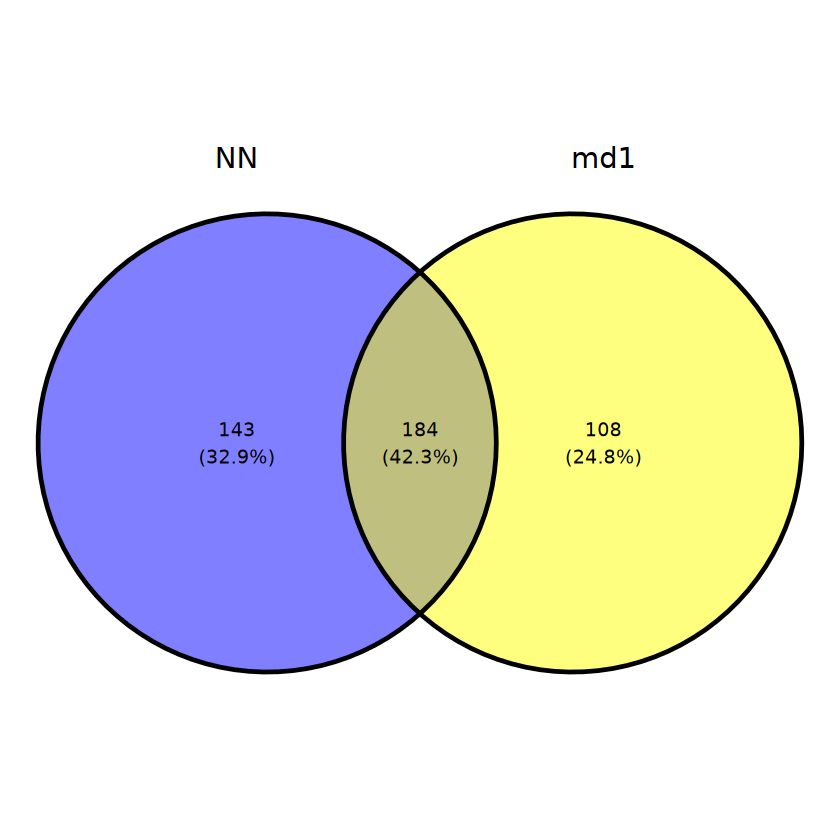

In [99]:
ggvenn(list("NN" = nng,"md1" = unique(mdcell[mdcell$cluster %in%c(3,4,6),]$gene_id)))

query   significant p_value      term_size query_size intersection_size
1  query_1 TRUE        8.842711e-03 3845      248         75              
2  query_1 TRUE        1.906730e-04 7200      241        141              
3  query_1 TRUE        2.187509e-02 4501      241         92              
4  query_1 TRUE        1.341759e-02 4322      241         90              
5  query_1 TRUE        7.463088e-05 3138      248         71              
6  query_1 TRUE        1.161382e-04 2985      248         68              
7  query_1 TRUE        4.287770e-02 1330      248         33              
8  query_1 TRUE        1.908691e-02 1331      248         34              
9  query_1 TRUE        5.489484e-03 1362      248         36              
10 query_1 TRUE        1.873589e-02 1161      241         34              
11 query_1 TRUE        1.496238e-02  880      248         26              
12 query_1 TRUE        4.367908e-02 2313      101         69              
13 query_1 TRUE        2.989615e-07 1688      248         52              
14 query_1 TRUE        2.853648e-02 1864      101         60              
15 query_1 TRUE        4.418246e-02  727      241         24              
16 query_1 TRUE        9.260544e-03 1094      101         43              
17 query_1 TRUE        1.571971e-02 1038      101         41              
18 query_1 TRUE        1.314672e-03  501      232         21              
19 query_1 TRUE        8.979756e-03  448      241         19              
20 query_1 TRUE        6.656421e-03  373      248         16              
21 query_1 TRUE        1.892600e-02  370      232         16              
22 query_1 TRUE        1.858178e-03  427      232         19              
23 query_1 TRUE        1.162412e-02  378      241         17              
24 query_1 TRUE        1.162412e-02  378      241         17              
25 query_1 TRUE        4.662303e-05  488      232         23              
26 query_1 TRUE        4.613376e-06  547      232         26              
27 query_1 TRUE        9.039374e-03  262      248         13              
28 query_1 TRUE        1.745240e-04  308      241         18              
29 query_1 TRUE        7.713203e-03  162      241         11              
30 query_1 TRUE        1.524333e-04  244      144         17              
31 query_1 TRUE        9.728302e-03  136      232         10              
32 query_1 TRUE        2.595308e-02  121      232          9              
33 query_1 TRUE        2.969952e-02   14      232          4              
34 query_1 TRUE        1.496922e-02   12      232          4              
35 query_1 TRUE        1.496922e-02   12      232          4              
   precision  recall     term_id    source
1  0.30241935 0.01950585 GO:0071944 GO:CC 
2  0.58506224 0.01958333 GO:0005515 GO:MF 
3  0.38174274 0.02043990 GO:0036094 GO:MF 
4  0.37344398 0.02082369 GO:0043167 GO:MF 
5  0.28629032 0.02262588 GO:0005654 GO:CC 
6  0.27419355 0.02278057 GO:0005829 GO:CC 
7  0.13306452 0.02481203 GO:0030054 GO:CC 
8  0.13709677 0.02554470 GO:0120025 GO:CC 
9  0.14516129 0.02643172 GO:0042995 GO:CC 
10 0.14107884 0.02928510 GO:0044877 GO:MF 
11 0.10483871 0.02954545 GO:0099080 GO:CC 
12 0.68316832 0.02983139 HP:0040064 HP    
13 0.20967742 0.03080569 GO:0005856 GO:CC 
14 0.59405941 0.03218884 HP:0001263 HP    
15 0.09958506 0.03301238 GO:0008092 GO:MF 
16 0.42574257 0.03930530 HP:0002463 HP    
17 0.40594059 0.03949904 HP:0000750 HP    
18 0.09051724 0.04191617 GO:0006325 GO:BP 
19 0.07883817 0.04241071 GO:0003682 GO:MF 
20 0.06451613 0.04289544 GO:0015629 GO:CC 
21 0.06896552 0.04324324 GO:0051493 GO:BP 
22 0.08189655 0.04449649 GO:0006338 GO:BP 
23 0.07053942 0.04497354 GO:0030695 GO:MF 
24 0.07053942 0.04497354 GO:0060589 GO:MF 
25 0.09913793 0.04713115 GO:0030036 GO:BP 
26 0.11206897 0.04753199 GO:0030029 GO:BP 
27 0.05241935 0.04961832 GO:0031252 GO:CC 
28 0.07468880 0.05844156 GO:0003779 GO:MF 
29 0.04564315 0.06790123 GO:0140030 GO:MF 
30 0.11805556

file saved to result/figure5/GO_analysis_NN_dtu_24_04_16.pdf



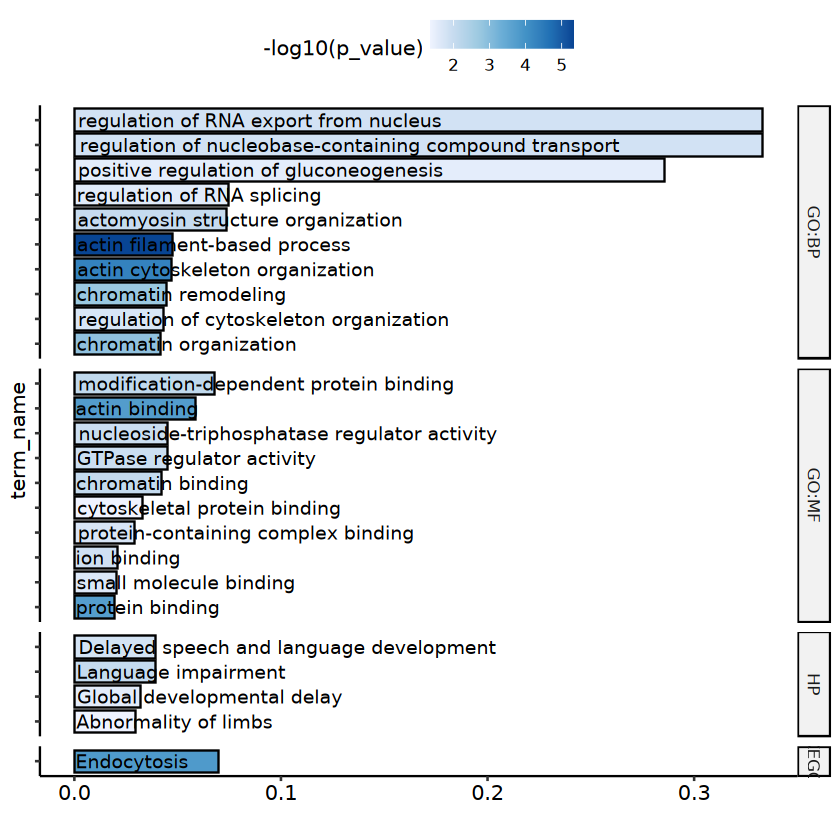

In [180]:
goi = gost(query = nng,
               organism = "mmulatta")
godfi = goi$result
godfi$gene_ratio = godfi$intersection_size/godfi$term_size
godfi = godfi[godfi$p_value < 0.05,]
godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(gene_ratio) %>% top_n(wt = gene_ratio,n = 10)
godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
godfi
pgo2 = ggplot(godfi[godfi$source != "GO:CC",],
               aes(x = gene_ratio, y=term_name,fill = -log10(p_value))) + 
    geom_bar(stat = "identity",color = "black") +
    geom_text(aes(label = term_name,x = 0),color = "black",hjust = -0.01) +
    scale_color_flatui() +
    scale_fill_distiller(direction = 1) +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    facet_grid(source~.,scales = "free",space = "free") + 
    xlab("") +
    theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank())
pgo2
ggexport(pgo2,filename = "result/figure5/GO_analysis_NN_dtu_24_04_16.pdf",width = 6,height = 5)

In [ ]:
godft = NULL
for (i in areaclid) {
    goi = gost(query = unique(sigdata[sigdata$areatr ==i &
                                        sigdata$sig != "N",]$gene),
               organism = "mmulatta")
    godfi = CalOddRate(goi$result[goi$result$source != "HP",],3)
    godfi2 = CalOddRate(goi$result[goi$result$source == "HP",],20)
    godfi = rbind(godfi,godfi2)
    godfi$group = i
    godft = rbind(godft, godfi)
}
  
  godft = godft[order(godft$group,godft$odds_ratio),]
  godftf = godft
  godftf = godft %>% group_by(group) %>% top_n(wt = odds_ratio,n = 10)
  # godft = godft %>% group_by(term_name) %>% filter(n() == 1)
  # godftf$term_name = factor(godftf$term_name,levels = unique(godftf$term_name))
  godftf$term_name_order = paste0(godftf$term_name,"-",godftf$group)
  godftf$term_name_order = factor(godftf$term_name_order,levels = unique(godftf$term_name_order))
  p6b = ggplot(godftf,
               aes(x = log(odds_ratio), y=term_name_order,size=-log10(p_value),
                   color = source)) + geom_point() +
    scale_color_brewer(palette = "Set1") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    facet_grid(group~.,scales = "free") + xlab("") +
    theme_pubr() + theme(legend.position = "top")
  p6b
  
  ggsave(p6b, filename = "processed/figures/f6/f6b.cellclass_unique_GO.pdf",
         width = 8,height = 8,units = "in")

### Isoform dispersion stat

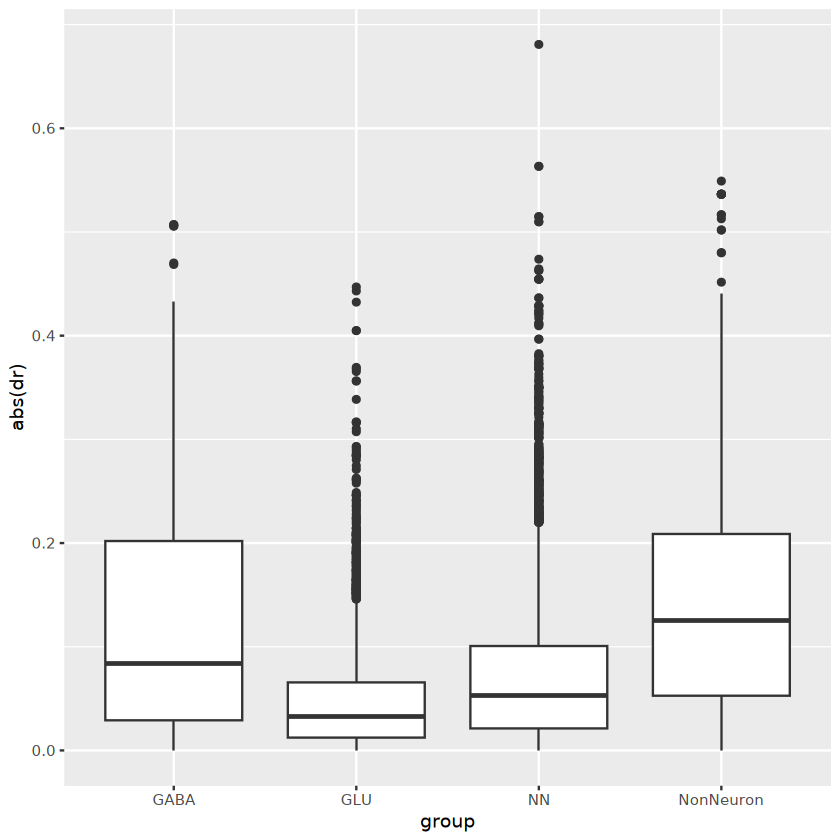

In [157]:
isodf = NULL
isosigi = isosigls.cl$GLU_GLU
isosigi = isosigi[isosigi$sig != "N" & isosigi$count > 10,]
isosigi$group = "GLU"
isodf = rbind(isodf,isosigi)

isosigi = isosigls.cl$GABA_GABA
isosigi = isosigi[isosigi$sig != "N" & isosigi$count > 10,]
isosigi$group = "GABA"
isodf = rbind(isodf,isosigi)

isosigi = isosigls.cl$NonNeuron_NonNeuron
isosigi = isosigi[isosigi$sig != "N" & isosigi$count > 10,]
isosigi$group = "NonNeuron"
isodf = rbind(isodf,isosigi)

isosigi = isosigls.cl$Neuron_NonNeuron
isosigi = isosigi[isosigi$sig != "N" & isosigi$count > 10,]
isosigi$group = "NN"
isodf = rbind(isodf,isosigi)
ggplot(isodf,aes(x = group,y = abs(dr))) + geom_boxplot()

deep-GLU    GABA       nonNeuron   nonNeuron-ASC nonNeuron-OLG
deep-GLU       1.00000000 -0.1752273 -0.13433063 -0.6409501    -0.41641201  
GABA          -0.17522728  1.0000000 -0.15392361 -0.2803089    -0.11090760  
nonNeuron     -0.13433063 -0.1539236  1.00000000  0.2704376     0.09010103  
nonNeuron-ASC -0.64095014 -0.2803089  0.27043761  1.0000000     0.35252472  
nonNeuron-OLG -0.41641201 -0.1109076  0.09010103  0.3525247     1.00000000  
surface-GLU    0.09995065 -0.1841268 -0.26463650 -0.3826088    -0.35886118  
              surface-GLU
deep-GLU       0.09995065
GABA          -0.18412680
nonNeuron     -0.26463650
nonNeuron-ASC -0.38260882
nonNeuron-OLG -0.35886118
surface-GLU    1.00000000

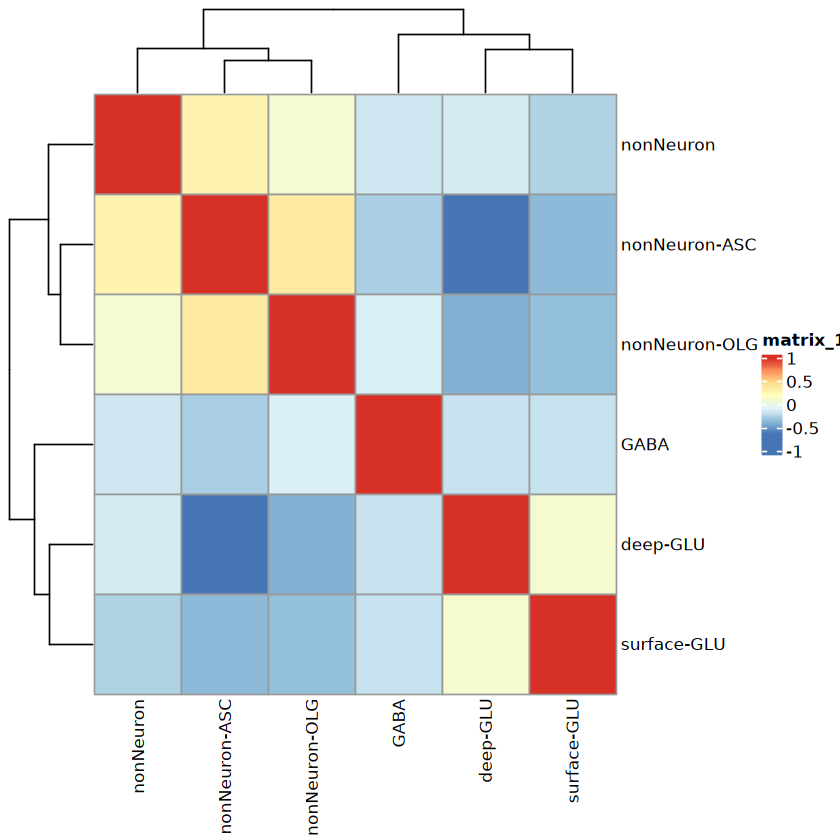

In [178]:
isosigi = isosigls$subclass
isosigi$dr2 = isosigi$relative - isosigi$meanrelative
isosigi = isosigi[isosigi$pvalue < 0.05,]
isosigi = isosigi %>% group_by(transcript_id) %>% filter(max(abs(dr2)) > 0.05)
isosigi$class = subclassan[match(isosigi$areatr,subclassan$subclass),]$class
isosig.mx = dcast(isosigi,transcript_id~class,value.var = "dr2",fun.aggregate = mean)
isosig.mx[is.na(isosig.mx)] = 0
rownames(isosig.mx) = isosig.mx$transcript_id;isosig.mx = isosig.mx[-1]
isosig.st = cor(isosig.mx,method = "spearman")
isosig.st
pheatmap(isosig.st)
# isosig.st = as.data.frame(isosig.st)
# isosig.st$V1 = rownames(isosig.st)
# isosig.st = melt(isosig.st)
# isosig.st = isosig.st[isosig.st$V1 != isosig.st$variable,]
# isosig.st$group1 = subclassan[match(isosig.st$V1,subclassan$subclass),]$class
# isosig.st$group2 = subclassan[match(isosig.st$variable,subclassan$subclass),]$class
# isosig.st$group = paste0(isosig.st$group1,"_",isosig.st$group2)
# head(isosig.st)

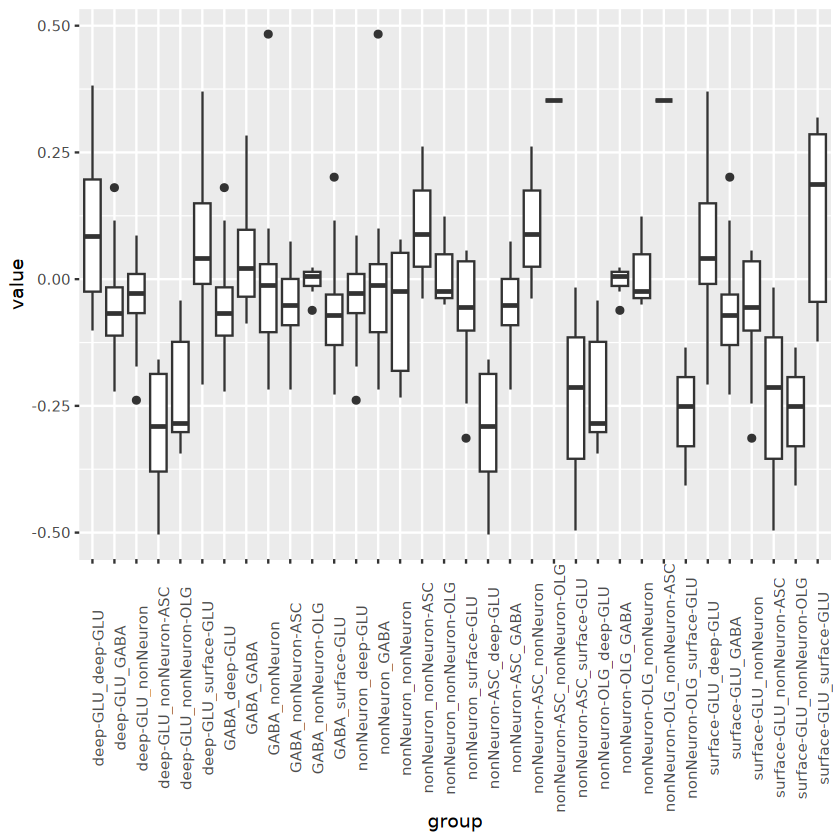

In [174]:
ggplot(isosig.st,aes(x = group,y = value)) + geom_boxplot() + theme(axis.text.x = element_text(angle = 90))

### Alternative splicing type analysis

In [181]:
ClassifyBubble = function(upgroup, downgroup, gtfp) {
  gtfup = gtfp[gtfp$transcript_id %in% upgroup & gtfp$type == "exon", 
                      c("gene_id","transcript_id") ]
  gtfdown = gtfp[gtfp$transcript_id %in% downgroup & gtfp$type == "exon", 
                        c("gene_id","transcript_id")]
  resls = c()
  
  #pre data
  strand = strand(gtfup)@values
  gtfup$exoname = paste0(start(gtfup),"-",end(gtfup))
  gtfup$mystart = start(gtfup)
  gtfup$myend = end(gtfup)
  
  gtfdown$exoname = paste0(start(gtfdown),"-",end(gtfdown))
  gtfdown$mystart = start(gtfdown)
  gtfdown$myend = end(gtfdown)
  
  gtfupdf = as.data.frame(gtfup)
  gtfdowndf = as.data.frame(gtfdown)
  if(strand == "+"){
    gtfupdf = gtfupdf[order(gtfupdf$exoname),]
    gtfdowndf = gtfdowndf[order(gtfdowndf$exoname),]
  }else{
    gtfupdf = gtfupdf[order(gtfupdf$exoname,decreasing = T),]
    gtfdowndf = gtfdowndf[order(gtfdowndf$exoname,decreasing = T),]
  }
  exontsup = gtfupdf %>% group_by(transcript_id) %>% 
    summarise(exonss = exoname[1], exonse = exoname[length(exoname)])
  exontsdown = gtfdowndf %>% group_by(transcript_id) %>% 
    summarise(exonss = exoname[1], exonse = exoname[length(exoname)])
  
  if(length(intersect(gtfup$mystart,gtfdown$mystart)) == 0 &
     length(intersect(gtfup$myend,gtfdown$myend)) == 0){
    return("Alldiff")
  }
  
  #if group
  transidu = unique(gtfup$transcript_id)
  gtfupc = gtfup[gtfup$transcript_id == transidu[1]]
  if(length(transidu) > 1){
    for (i in 2:length(transidu)) {
      gtfupi = gtfup[gtfup$transcript_id == transidu[i]]
      hiti = findOverlaps(gtfupc, gtfupi)
      gtfupc = unique(gtfupc[queryHits(hiti)])
    }
  }
  # transidd = unique(gtfdown$transcript_id)
  gtfdownc = unique(gtfdown)
  # if(length(transidd) > 1){
  #   for (i in 2:length(transidd)) {
  #     gtfdowni = gtfdown[gtfdown$transcript_id == transidd[i]]
  #     hiti = findOverlaps(gtfdownc,gtfdowni)
  #     gtfdownc = gtfdownc[queryHits(hiti)]
  #   }
  # }
  exoverlap = findOverlaps(gtfupc, gtfdownc)
  
  
  cmpdf = data.frame("exonameUp" = gtfupc[queryHits(exoverlap)]$exoname,
                     "exonameDown" = gtfdownc[subjectHits(exoverlap)]$exoname,
                     "startUp" = gtfupc[queryHits(exoverlap)]$mystart,
                     "startDown" = gtfdownc[subjectHits(exoverlap)]$mystart,
                     "endUp" = gtfupc[queryHits(exoverlap)]$myend,
                     "endDown" = gtfdownc[subjectHits(exoverlap)]$myend)
  
  #A5SS/A3SS/DSS/IR
  # gtfupa = gtfup[!gtfup$exoname %in% gtfdown$exoname,]
  # gtfdowna = gtfdown[!gtfdown$exoname %in% gtfup$exoname,]
  cmpdfss = cmpdf[!(cmpdf$exonameUp %in% gtfdown$exoname) &
                    !(cmpdf$exonameDown %in% gtfup$exoname), ]
  cmpdfssid = unique(cmpdfss$exonameUp)
  
  if(length(cmpdfssid) > 0){
    for (i in 1:length(cmpdfssid)) {
      cmpdfi = cmpdfss[cmpdfss$exonameUp == cmpdfssid[i],]
      
      loci = NULL
      typei = NULL
      iri = NULL
      
      sscmp = c(intersect(cmpdfi$exonameUp, exontsup$exonss))
      secmp = c(intersect(cmpdfi$exonameUp, exontsup$exonse))
      if(length(sscmp) > 0){
        loci = "FE"
      }else if(length(secmp) > 0){
        loci = "LE"
      }else{
        loci = "ME"
      }
      
      if(nrow(cmpdfi) > 1){
        cmpdfi = cmpdfi[order(cmpdfi$startDown), ]
        no_intersection = all(cmpdfi$endDown[-nrow(cmpdfi)] < cmpdfi$startDown[-1])
        if(no_intersection){
          iri = "IR"
        }
      }
      
      startcmp = intersect(cmpdfi$startUp, cmpdfi$startDown)
      endcmp = intersect(cmpdfi$endUp, cmpdfi$endDown)
      if(length(startcmp) != 0 & length(endcmp) == 0){
        if(strand == "+"){
          typei = "A3SS"
        }else{
          typei = "A5SS"
        }
      }else if(length(startcmp) == 0 & length(endcmp) != 0){
        if(strand == "+"){
          typei = "A5SS"
        }else{
          typei = "A3SS"
        }
      }else{
        typei = "DSS"
      }
      resi = paste0(c(loci,typei,iri),collapse = "-")
      resls = unique(c(resls, resi))
    }
    
  }
  
  #ES/AFE/ALE/MXE
  #AFE
  newess = setdiff(exontsup$exonss, exontsdown$exonss)
  newess = newess[newess %in% gtfupc$exoname]
  newess = newess[!newess %in% cmpdfss[cmpdfss$exonameDown %in% exontsdown$exonss,]$exonameUp]
  if(length(newess) != 0){
    if(length(intersect(newess, gtfdowndf$exoname)) == 0){
      resls = c(resls,"New-AFE")
    }else{
      resls = c(resls,"Kn-AFE")
    }
  }
  
  #ALE
  newese = setdiff(exontsup$exonse, exontsdown$exonse)
  newese = newese[newese %in% gtfupc$exoname]
  newese = newese[!newese %in% cmpdfss[cmpdfss$exonameDown %in% exontsdown$exonse,]$exonameUp]
  
  if(length(newese) != 0){
    if(length(intersect(newese, gtfdowndf$exoname)) == 0){
      resls = c(resls,"New-ALE")
    }else{
      resls = c(resls,"Kn-ALE")
    }
  }
  
  #ES
  newesu = gtfupdf[gtfupdf$start > min(gtfdowndf$start) &
                     gtfupdf$end < max(gtfdowndf$end), ]$exoname
  newesu = newesu[!newesu %in% cmpdf$exonameUp]
  newesu = newesu[!newesu %in% c(exontsup$exonse,exontsup$exonss)]
  newesu = newesu[newesu %in% gtfupc$exoname]
  
  newesd = gtfdowndf[gtfdowndf$start > min(gtfupdf$start) &
                       gtfdowndf$end < max(gtfupdf$end),]$exoname
  newesd = newesd[!newesd %in% cmpdf$exonameDown]
  newesd = newesd[!newesd %in% c(exontsdown$exonse,exontsdown$exonss)]
  newesd = newesd[newesd %in% gtfdownc$exoname]
  
  if(length(newesu) != 0 & length(newesd) != 0){
    resls = c(resls,"MXE")
  }else if(length(newesu) != 0 & length(newesd) == 0){
    resls = c(resls,"CE")
  }else if(length(newesu) == 0 & length(newesd) != 0){
    resls = c(resls,"ES")
  }
  
  resls = unique(resls)
  if(length(resls) == 0) return("Complex")
  return(resls)
}


In [196]:
MakeCmpGroup = function(isosigref){
    isosighub = isosigref[isosigref$sig != "N" & isosigref$sig != "Y",]
    if(nrow(isosighub) == 0) return(NULL)
    genels = unique(isosighub$gene_id)
    cmpdf = NULL
    for (i in 1:length(genels)) {
      isline = isosighub[isosighub$gene_id == genels[i],]
      islineref = isosigref[isosigref$gene_id == genels[i],]
      upgroup = isline[isline$sig == "Up",]$transcript_id
      downgroup = isline[isline$sig == "Down",]$transcript_id
      if(length(upgroup) == 0 & length(downgroup) > 0){
        upgroup = unique(islineref[!islineref$transcript_id %in% downgroup,]$transcript_id)
      }
      if(length(downgroup) == 0 & length(upgroup) > 0){
        downgroup = unique(islineref[!islineref$transcript_id %in% upgroup,]$transcript_id)
      }
      cmpdf = rbind(cmpdf,data.frame("up" = paste0(upgroup,collapse = "|"),
                                     "down" = paste0(downgroup,collapse = "|"),
                                     "gene" = genels[i]))
      # cmpls[[i]] = list("up" = upgroup,"down" = downgroup)
    }
    return(cmpdf)
}

PosProcessAlt = function(cmpdf){
    cmpdf = cmpdf[cmpdf$up != "" & cmpdf$down != "",]
cmpdfd = cmpdf
cmpdfd$cmptypestr = ""
for (i in 1:nrow(cmpdfd)) {
    print(i)
    upgroup = cmpdfd[i,]$up
    downgroup = cmpdfd[i,]$down
    upgroup = unlist(strsplit(upgroup,"\\|"))
    downgroup = unlist(strsplit(downgroup,"\\|"))
    cmptypei = ClassifyBubble(upgroup,downgroup,gtf)
    cmptypei = cmptypei[order(cmptypei)]
    cmptypei = paste0(cmptypei,collapse = "|")
    print(cmptypei)
    cmpdfd$cmptypestr[i] = cmptypei 
}
cmpdfd$cmptypels = strsplit(cmpdfd$cmptypestr,"\\|")
cmpdftdl2 = data.frame("gene" = rep(cmpdfd$gene,lengths(cmpdfd$cmptypels)),
                           "group" = rep(cmpdfd$areatr,lengths(cmpdfd$cmptypels)),
                           "cmptype" = unlist(cmpdfd$cmptypels))
cmpdftdl2$cmptypehub = cmpdftdl2$cmptype
cmpdftdl2$cmptypepos = cmpdftdl2$cmptype
    
cmpdftdl2[grepl("FE|AFE",cmpdftdl2$cmptype),]$cmptypepos = "FE"
cmpdftdl2[grepl("LE|ALE",cmpdftdl2$cmptype),]$cmptypepos = "LE"
cmpdftdl2[grepl("ME|CE|ES|MXE",cmpdftdl2$cmptype),]$cmptypepos = "ME"
cmpdftdl2[grepl("ALE",cmpdftdl2$cmptype),]$cmptypehub = "ALE"
cmpdftdl2[grepl("AFE",cmpdftdl2$cmptype),]$cmptypehub = "AFE"
cmpdftdl2[grepl("A5SS",cmpdftdl2$cmptype),]$cmptypehub = "A3SS"
cmpdftdl2[grepl("A3SS",cmpdftdl2$cmptype),]$cmptypehub = "A5SS"
cmpdftdl2[grepl("DSS",cmpdftdl2$cmptype),]$cmptypehub = "DSS"
cmpdftdl2[grepl("CE",cmpdftdl2$cmptype),]$cmptypehub = "ES"
    return(cmpdftdl2)
}

In [192]:
isosigi = isosigls.cl$GLU_GLU
cmpdf = NULL
isosigi = isosigi[isosigi$transcript_id %in% fsrawdp$transcript_id,]
areatr = unique(isosigi$areatr)
for (j in 1:length(areatr)) {
      cmpdfj = MakeCmpGroup(isosigi[isosigi$areatr == areatr[j],])
      if(is.null(cmpdfj)) next
      cmpdfj$areatr = areatr[j]
      cmpdf = rbind(cmpdf,cmpdfj)
}
nrow(cmpdf)
cmpdftdl2 = PosProcessAlt(cmpdf)

[1] 1
[1] "ES|New-ALE"
[1] 2
[1] "Alldiff"
[1] 3
[1] "LE-A3SS|ME-A5SS|New-AFE"
[1] 4
[1] "FE-A5SS|ME-A3SS|New-AFE|New-ALE"
[1] 5
[1] "LE-A3SS|New-AFE"
[1] 6
[1] "New-ALE"
[1] 7
[1] "FE-A5SS|New-ALE"
[1] 8
[1] "Alldiff"
[1] 9
[1] "ES|New-AFE"
[1] 10
[1] "ES"
[1] 11
[1] "ES|LE-A3SS"
[1] 12
[1] "ES|New-ALE"
[1] 13
[1] "Alldiff"
[1] 14
[1] "ME-A5SS"
[1] 15
[1] "FE-A5SS|New-ALE"
[1] 16
[1] "LE-A3SS|ME-A5SS|New-AFE"
[1] 17
[1] "LE-A3SS|New-AFE"
[1] 18
[1] "Alldiff"
[1] 19
[1] "ES|LE-A3SS|New-AFE"
[1] 20
[1] "CE|FE-A5SS|LE-A3SS"
[1] 21
[1] "ES|FE-A5SS|LE-A3SS|ME-A5SS"
[1] 22
[1] "ES"
[1] 23
[1] "ES"
[1] 24
[1] "LE-A5SS"
[1] 25
[1] "ES"
[1] 26
[1] "ES|LE-A3SS"
[1] 27
[1] "Alldiff"
[1] 28
[1] "ES"
[1] 29
[1] "ES|FE-A5SS|LE-A3SS|New-ALE"
[1] 30
[1] "ES|FE-A5SS|New-AFE"
[1] 31
[1] "ES"
[1] 32
[1] "ES|New-ALE"
[1] 33
[1] "ES|New-AFE|New-ALE"
[1] 34
[1] "ES"
[1] 35
[1] "LE-A3SS|ME-A5SS|New-AFE|New-ALE"
[1] 36
[1] "LE-A3SS|New-AFE"
[1] 37
[1] "ES|FE-A5SS"
[1] 38
[1] "ME-A3SS"
[1] 39
[1] "CE|FE-A5SS"

up                                                                                                                                                                                                                                                                                                                                       
1   XM_005545495.2|XM_005545496.2|XM_005545497.2|XM_015444972.1                                                                                                                                                                                                                                                                              
3   NM_001284187.1                                                                                                                                                                                                                                                                                                                           
4   XM_005580962.1                                                                                                                                                                                                                                                                                                                           
5   XM_005564363.2                                                                                                                                                                                                                                                                                                                           
6   DDRGK1-WeiLab-1                                                                                                                                                                                                                                                                                                                          
7   XM_015429851.1|XM_015429853.1                                                                                                                                                                                                                                                                                                            
8   LOC102125970-WeiLab-1|XR_001483497.1|XR_001483499.1|XR_001483500.1                                                                                                                                                                                                                                                                       
9   LOC102130709-WeiLab-6|LOC102130709-WeiLab-7                                                                                                                                                                                                                                                                                              
10  XR_001489182.1                                                                                                                                                                                                                                                                                                                           
11  XM_005540045.2|XM_005540046.2|XM_005540047.2|XM_005540048.2|XM_015445778.1|XM_015445784.1|XM_015445804.1                                                                                                                                                                                                                                 
12  XM_015434151.1|XM_015434162.1                                                                                                                                                                                                                                                                                                         

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


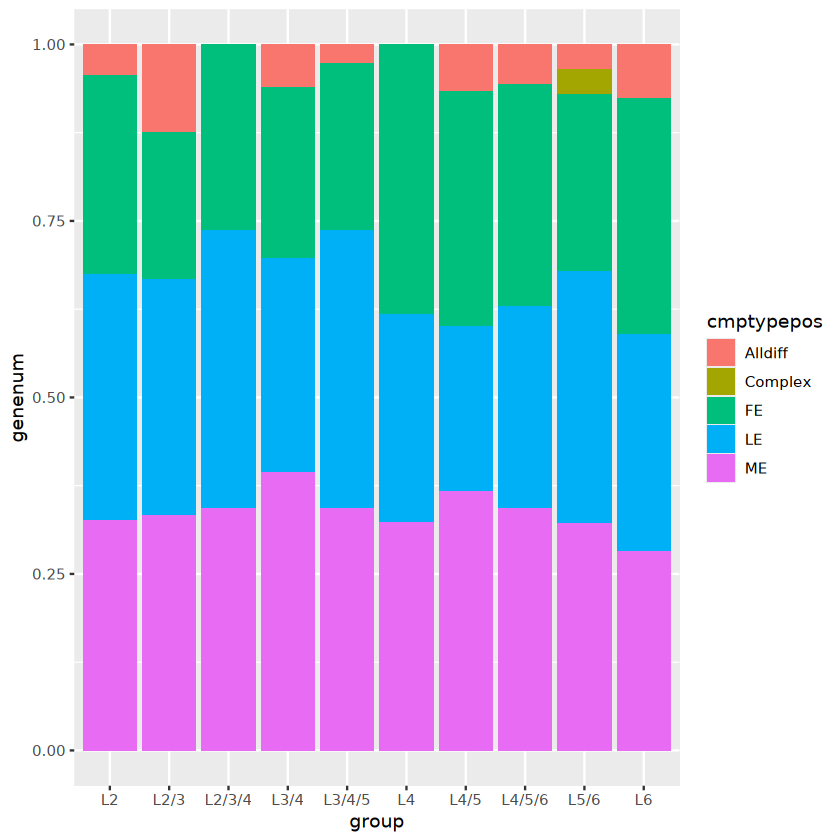

In [200]:

#cmpdftdl2.st = cmpdftdl2 %>% group_by(group,gene) %>% mutate(posnum = length(unique(cmptypepos)))
#cmpdftdl2.st[cmpdftdl2.st$posnum > 1,]$cmptypepos = "Multiple"
#cmpdftdl2.st = cmpdftdl2.st %>% group_by(group,gene) %>% summarise(postype = unique(cmptypepos))
cmpdftdl2.st = cmpdftdl2 %>% group_by(group,cmptypepos) %>% summarise(genenum = length(unique(gene)))
ggplot(cmpdftdl2.st,aes(x = group,y = genenum,fill = cmptypepos)) + geom_bar(stat = "identity",position = "fill")

[1] 541

[1] 1
[1] "ES"
[1] 2
[1] "New-ALE"
[1] 3
[1] "ES"
[1] 4
[1] "FE-A5SS|New-ALE"
[1] 5
[1] "ES|New-ALE"
[1] 6
[1] "New-ALE"
[1] 7
[1] "ES"
[1] 8
[1] "ES"
[1] 9
[1] "FE-A5SS|New-ALE"
[1] 10
[1] "ES"
[1] 11
[1] "ME-A3SS|New-ALE"
[1] 12
[1] "ES|New-ALE"
[1] 13
[1] "FE-A5SS|LE-A3SS|New-AFE"
[1] 14
[1] "New-AFE|New-ALE"
[1] 15
[1] "New-AFE"
[1] 16
[1] "New-AFE|New-ALE"
[1] 17
[1] "FE-A5SS|LE-A3SS|New-ALE"
[1] 18
[1] "ES"
[1] 19
[1] "ES|LE-A3SS"
[1] 20
[1] "LE-A3SS|New-AFE"
[1] 21
[1] "New-ALE"
[1] 22
[1] "FE-A5SS|LE-DSS"
[1] 23
[1] "Alldiff"
[1] 24
[1] "FE-A5SS|ME-A3SS|New-ALE"
[1] 25
[1] "FE-A5SS|LE-A3SS|New-AFE"
[1] 26
[1] "ME-A5SS|New-AFE"
[1] 27
[1] "ES|FE-A5SS"
[1] 28
[1] "ES|FE-A5SS|New-ALE"
[1] 29
[1] "ES|New-ALE"
[1] 30
[1] "ES|New-AFE"
[1] 31
[1] "ES|FE-A5SS"
[1] 32
[1] "ES|FE-A5SS|New-ALE"
[1] 33
[1] "ES|FE-A5SS|LE-A3SS"
[1] 34
[1] "Alldiff"
[1] 35
[1] "New-ALE"
[1] 36
[1] "ES|FE-A5SS|ME-A5SS"
[1] 37
[1] "FE-A5SS|ME-DSS"
[1] 38
[1] "ES|LE-A3SS"
[1] 39
[1] "CE|LE-A3SS"
[1] 40
[1] "LE-

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


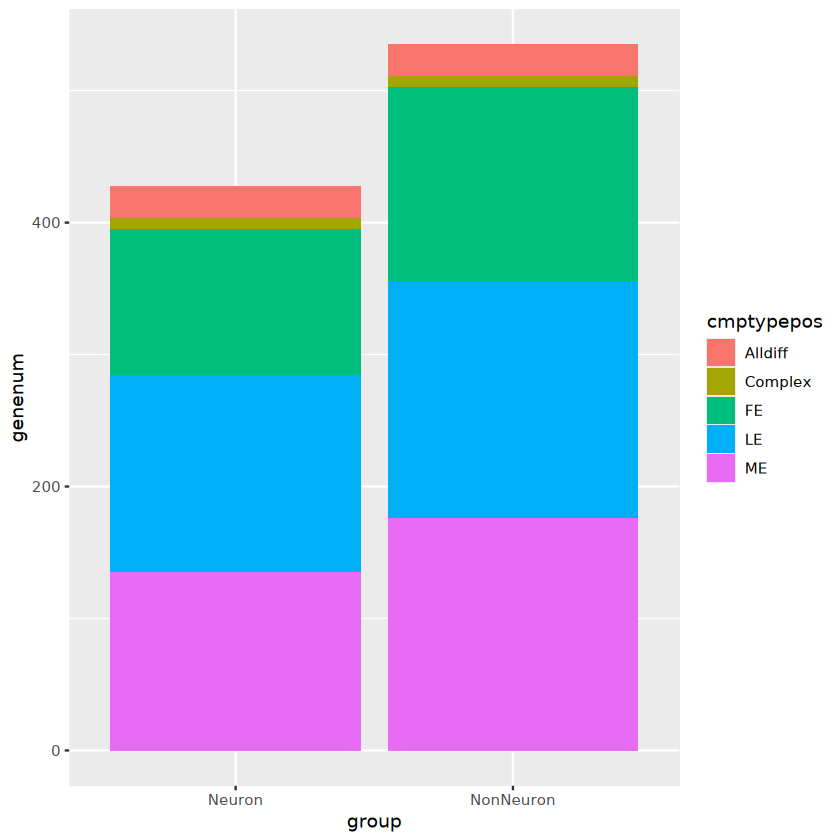

In [197]:
isosigi = isosigls.cl$Neuron_NonNeuron
cmpdf2 = NULL
isosigi = isosigi[isosigi$transcript_id %in% fsrawdp$transcript_id,]
areatr = unique(isosigi$areatr)
for (j in 1:length(areatr)) {
      cmpdfj = MakeCmpGroup(isosigi[isosigi$areatr == areatr[j],])
      if(is.null(cmpdfj)) next
      cmpdfj$areatr = areatr[j]
      cmpdf2 = rbind(cmpdf2,cmpdfj)
}
nrow(cmpdf2)
cmpdftdl3 = PosProcessAlt(cmpdf2)
cmpdftdl3.st = cmpdftdl3 %>% group_by(group,cmptypepos) %>% summarise(genenum = length(unique(gene)))


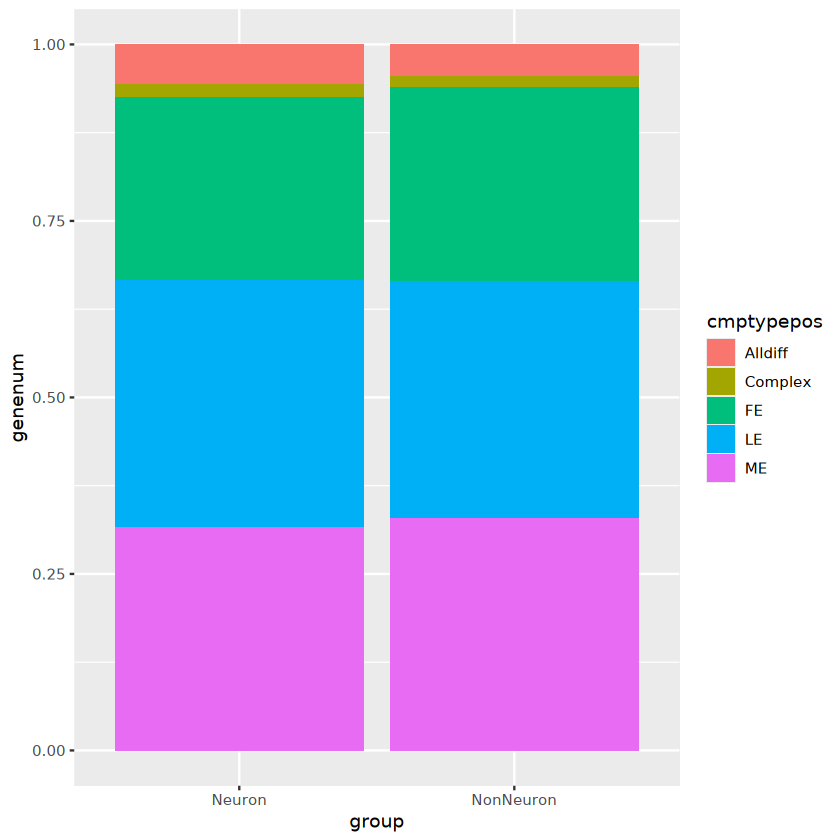

In [199]:
ggplot(cmpdftdl3.st,aes(x = group,y = genenum,fill = cmptypepos)) + geom_bar(stat = "identity",position = "fill")

In [ ]:
#isoform type of different cell type
{
  gtfp
  isosigi = isosigls.cl$GABA_GABA
  isosigls
  MakeCmpGroup = function(isosigref){
    isosighub = isosigref[isosigref$sig != "N" & isosigref$sig != "Y",]
    if(nrow(isosighub) == 0) return(NULL)
    genels = unique(isosighub$gene_id)
    cmpdf = NULL
    for (i in 1:length(genels)) {
      isline = isosighub[isosighub$gene_id == genels[i],]
      islineref = isosigref[isosigref$gene_id == genels[i],]
      upgroup = isline[isline$sig == "Up",]$transcript_id
      downgroup = isline[isline$sig == "Down",]$transcript_id
      if(length(upgroup) == 0 & length(downgroup) > 0){
        upgroup = unique(islineref[!islineref$transcript_id %in% downgroup,]$transcript_id)
      }
      if(length(downgroup) == 0 & length(upgroup) > 0){
        downgroup = unique(islineref[!islineref$transcript_id %in% upgroup,]$transcript_id)
      }
      cmpdf = rbind(cmpdf,data.frame("up" = paste0(upgroup,collapse = "|"),
                                     "down" = paste0(downgroup,collapse = "|"),
                                     "gene" = genels[i]))
      # cmpls[[i]] = list("up" = upgroup,"down" = downgroup)
    }
    return(cmpdf)
  }
  
  cmpdft = NULL
  for(i in 1:length(isosigls)){
    print(names(isosigls)[i])
    cmpdf = NULL
    isosigi = isosigls[[i]]
    areatr = unique(isosigi$areatr)
    for (j in 1:length(areatr)) {
      cmpdfj = MakeCmpGroup(isosigi[isosigi$areatr == areatr[j],])
      if(is.null(cmpdfj)) next
      cmpdfj$areatr = areatr[j]
      cmpdf = rbind(cmpdf,cmpdfj)
    }
    cmpdf$group = names(isosigls)[i]
    cmpdft = rbind(cmpdft,cmpdf)
  }
  
  for(i in 1:length(isosigls.cl)){
    print(names(isosigls.cl)[i])
    cmpdf = NULL
    isosigi = isosigls.cl[[i]]
    areatr = unique(isosigi$areatr)
    for (j in 1:length(areatr)) {
      cmpdfj = MakeCmpGroup(isosigi[isosigi$areatr == areatr[j],])
      if(is.null(cmpdfj)) next
      cmpdfj$areatr = areatr[j]
      cmpdf = rbind(cmpdf,cmpdfj)
    }
    cmpdf$group = names(isosigls.cl)[i]
    cmpdft = rbind(cmpdft,cmpdf)
  }
  qsave(cmpdft,file = "processed/figures/f3/bambu_sig_isoform_transcmpgroup_23_12_06.qs")
  cmpdft = qread("processed/figures/f3/bambu_sig_isoform_transcmpgroup_23_12_06.qs")
  
  cmpdft = cmpdft[cmpdft$up != "" & cmpdft$down != "",]
  cmpdftd = unique(cmpdft[1:3])
  cmpdftd$cmptypestr = ""
  for (i in 1:nrow(cmpdftd)) {
    print(i)
    upgroup = cmpdftd[i,]$up
    downgroup = cmpdftd[i,]$down
    upgroup = unlist(strsplit(upgroup,"\\|"))
    downgroup = unlist(strsplit(downgroup,"\\|"))
    cmptypei = ClassifyBubble(upgroup,downgroup,gtfp)
    cmptypei = cmptypei[order(cmptypei)]
    cmptypei = paste0(cmptypei,collapse = "|")
    print(cmptypei)
    cmpdftd$cmptypestr[i] = cmptypei 
  }
  qsave(cmpdftd,file = "processed/figures/f3/bambu_sig_isoform_transcmpgroup_cmptype_23_12_06.qs")
  cmpdftd = qread("processed/figures/f3/bambu_sig_isoform_transcmpgroup_cmptype_23_12_06.qs")
  cmpdftd = merge(cmpdftd,cmpdft,by = c("up","down","gene"))
  cmpst = as.data.frame(table(cmpdftd$cmptypestr))
  qsave(cmpdftd,file = "processed/figures/f3/bambu_sig_isoform_transcmpgroup_cmptype_23_12_06.qs")
  
  #statistic
  cmpdftd$cmptypels = strsplit(cmpdftd$cmptypestr,"\\|")
  cmpdftd$cmptypels
  cmpdftdl = data.frame("gene" = rep(cmpdftd$gene,lengths(cmpdftd$cmptypels)),
                        "areatr" = rep(cmpdftd$areatr,lengths(cmpdftd$cmptypels)),
                        "group" = rep(cmpdftd$group,lengths(cmpdftd$cmptypels)),
                        "cmptype" = unlist(cmpdftd$cmptypels))
  cmpst = cmpdftdl %>% group_by(group,areatr,cmptype) %>% summarise(count = n())
  colorstmp = rainbow(length(unique(cmpst$cmptype)),s = 0.75)
  colorstmp = colorstmp[sample(1:length(colorstmp),length(colorstmp))]
  
  library(colorspace)
  pt = ggplot(cmpst,
         aes(x = areatr, y = count,fill = cmptype)) + 
    geom_bar(stat = "identity",position = "fill") + 
    facet_grid(~group,scales = "free",space = "free") + 
    # scale_fill_discreterainbow() + 
    scale_fill_manual(values = colorstmp) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90)) + 
    xlab("") + ylab("")
  pt
  ggexport(pt,filename = "processed/figures/f3/bambu_sig_iso_cmptype_total.pdf",
         width = 20,height = 6)
  pt2 = ggplot(cmpst,
              aes(x = areatr, y = count,fill = cmptype)) + 
    geom_bar(stat = "identity") + 
    facet_grid(~group,scales = "free",space = "free") + 
    # scale_fill_discreterainbow() + 
    scale_fill_manual(values = colorstmp) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90)) + 
    xlab("") + ylab("")
  pt2
  ggexport(pt2,filename = "processed/figures/f3/bambu_sig_iso_cmptype_total_count.pdf",
           width = 20,height = 6)
  
  #compare hub type in celltype
  {
    cmpdftd$cmptypels = strsplit(cmpdftd$cmptypestr,"\\|")
    nrow(cmpdftd)
    cmpdftd2 = unique(cmpdftd[-c(1,2,5)])
    nrow(cmpdftd2)
    cmpdftd2$cmptypels
    cmpdftdl2 = data.frame("gene" = rep(cmpdftd2$gene,lengths(cmpdftd2$cmptypels)),
                           "group" = rep(cmpdftd2$group,lengths(cmpdftd2$cmptypels)),
                           "cmptype" = unlist(cmpdftd2$cmptypels))
    cmpdftdl2$cmptypehub = cmpdftdl2$cmptype
    cmpdftdl2$cmptypepos = cmpdftdl2$cmptype
    
    cmpdftdl2[grepl("FE|AFE",cmpdftdl2$cmptype),]$cmptypepos = "FE"
    cmpdftdl2[grepl("LE|ALE",cmpdftdl2$cmptype),]$cmptypepos = "LE"
    cmpdftdl2[grepl("ME|CE|ES|MXE",cmpdftdl2$cmptype),]$cmptypepos = "ME"
    cmpdftdl2[grepl("ALE",cmpdftdl2$cmptype),]$cmptypehub = "ALE"
    cmpdftdl2[grepl("AFE",cmpdftdl2$cmptype),]$cmptypehub = "AFE"
    cmpdftdl2[grepl("A5SS",cmpdftdl2$cmptype),]$cmptypehub = "A3SS"
    cmpdftdl2[grepl("A3SS",cmpdftdl2$cmptype),]$cmptypehub = "A5SS"
    cmpdftdl2[grepl("DSS",cmpdftdl2$cmptype),]$cmptypehub = "DSS"
    cmpdftdl2[grepl("CE",cmpdftdl2$cmptype),]$cmptypehub = "ES"
    cmpdftdl2[grepl("IR",cmpdftdl2$cmptype),]$cmptypehub = "IR"
    cmpdftdl2[cmpdftdl2$group %in% c("Neuron_NonNeuron","GLU_NonNeuron",
                                     "GABA_NonNeuron"),]$group = "Neuron_NonNeuron"
    cmpdftdl2 = unique(cmpdftdl2[-3])
    cmpst2 = cmpdftdl2 %>% group_by(group,gene,cmptypepos) %>% 
      summarise(cmptypehub = paste0(unique(cmptypehub[order(cmptypehub)]),
                                    collapse = "_"))
    cmpst2[grepl("ALE",cmpst2$cmptypehub),]$cmptypehub = "ALE"
    cmpst2[grepl("AFE",cmpst2$cmptypehub),]$cmptypehub = "AFE"
    cmpst2[grepl("_",cmpst2$cmptypehub),]$cmptypehub = "Complex2"
    
    cmpst2 = cmpst2 %>% group_by(group) %>% 
      mutate(genecount = length(unique(gene))) %>%
      group_by(group,cmptypepos,cmptypehub) %>% 
      summarise(count = length(unique(gene)),genecount = genecount[1])
    cmpst2 = cmpst2[!cmpst2$cmptypepos %in% c("Alldiff","Complex"),]
    
    cmpst2$prop = cmpst2$count/cmpst2$genecount
    # cmpst3 = cmpst3 %>% group_by(group) %>% 
    #   mutate(prop = count/sum(count))
    
    cmpst2$propstr = paste0(round(cmpst2$prop,3)*100,"%")
    cmpst2$cmptypehub = factor(cmpst2$cmptypehub, 
                               levels = c("A3SS","A5SS","DSS","AFE","ALE",
                                          "ES","MXE","Complex2"))
    
    
    cmpst2.1 = cmpst2[cmpst2$group %in% names(isosigls.cl),]
    cmpst2.1$group = factor(cmpst2.1$group,levels = c("GABA_GLU","GLU_GLU","GABA_GABA",
                                                      "Neuron_NonNeuron","NonNeuron_NonNeuron"))
    
    pt4 = ggplot(cmpst2.1,
                 aes(x = cmptypepos, y = prop,fill = cmptypehub)) + 
      # geom_bar(stat = "identity") +
      geom_bar(stat = "identity",position = "stack",
               width = 0.7) +
      geom_text(aes(label = propstr),position = position_stack(0.5),
                vjust = 1) +
      facet_grid(~group,space = "free",scales = "free") +
      scale_fill_discreterainbow() +
      # scale_fill_manual(values = colorstmp) + 
      theme_bw() +
      theme(axis.text.x = element_text(angle = 90)) + 
      xlab("") + ylab("")
    pt4
    ggexport(pt4,filename = "processed/figures/f3/bambu_sig_iso_cmptypepos_hub_celltype_23_12_07.pdf",
             width = 10,height = 5)
    write.csv(cmpst2,row.names = F,quote = F,
              file = "processed/figures/f3/bambu_sig_iso_cmptypepos_hub_celltype_23_12_07.csv")
    
  }
  
  #compare areatr in region
  mygroup = "layer"
  CompareType  = function(cmpdftd,mygroup){
    cmpdftdl = data.frame("gene" = rep(cmpdftd$gene,lengths(cmpdftd$cmptypels)),
                          "areatr" = rep(cmpdftd$areatr,lengths(cmpdftd$cmptypels)),
                          "group" = rep(cmpdftd$group,lengths(cmpdftd$cmptypels)),
                          "cmptype" = unlist(cmpdftd$cmptypels))
    cmpdftdl = unique(cmpdftdl)
    cmpdftdl$cmptypehub = cmpdftdl$cmptype
    cmpdftdl$cmptypepos = cmpdftdl$cmptype
    
    cmpdftdl[grepl("FE|AFE",cmpdftdl$cmptype),]$cmptypepos = "FE"
    cmpdftdl[grepl("LE|ALE",cmpdftdl$cmptype),]$cmptypepos = "LE"
    cmpdftdl[grepl("ME|CE|ES|MXE",cmpdftdl$cmptype),]$cmptypepos = "ME"
    cmpdftdl[grepl("ALE",cmpdftdl$cmptype),]$cmptypehub = "ALE"
    cmpdftdl[grepl("AFE",cmpdftdl$cmptype),]$cmptypehub = "AFE"
    #findaltts mistake, edit it here
    cmpdftdl[grepl("A5SS",cmpdftdl$cmptype),]$cmptypehub = "A3SS"
    cmpdftdl[grepl("A3SS",cmpdftdl$cmptype),]$cmptypehub = "A5SS"
    cmpdftdl[grepl("DSS",cmpdftdl$cmptype),]$cmptypehub = "DSS"
    cmpdftdl[grepl("CE",cmpdftdl$cmptype),]$cmptypehub = "ES"
    cmpdftdl[grepl("IR",cmpdftdl$cmptype),]$cmptypehub = "IR"
    
    cmpdftdl = unique(cmpdftdl[-4])
    cmpst = cmpdftdl %>% group_by(group,areatr,gene,cmptypepos) %>% 
      summarise(cmptypehub = paste0(unique(cmptypehub[order(cmptypehub)]),
                                    collapse = "_"))
    cmpst[grepl("ALE",cmpst$cmptypehub),]$cmptypehub = "ALE"
    cmpst[grepl("AFE",cmpst$cmptypehub),]$cmptypehub = "AFE"
    cmpst[grepl("_",cmpst$cmptypehub),]$cmptypehub = "Complex2"
    
    cmpst = cmpst %>% group_by(group,areatr) %>% 
      mutate(genecount = length(unique(gene))) %>%
      group_by(group,areatr,cmptypepos,cmptypehub) %>% 
      summarise(count = length(unique(gene)),genecount = genecount[1])
    cmpst = cmpst[!cmpst$cmptypepos %in% c("Alldiff","Complex"),]
    
    cmpst$prop = cmpst$count/cmpst$genecount
    # cmpst3 = cmpst3 %>% group_by(group) %>% 
    #   mutate(prop = count/sum(count))
    
    cmpst$propstr = paste0(round(cmpst$prop,3)*100,"%")
    cmpst$cmptypehub = factor(cmpst$cmptypehub, 
                               levels = c("A3SS","A5SS","DSS","AFE","ALE",
                                          "ES","MXE","IR","Complex2"))
    
    
    cmpstf = cmpst[cmpst$group %in% mygroup,]
    pt = ggplot(cmpstf,
                 aes(x = cmptypepos, y = prop,fill = cmptypehub)) + 
      # geom_bar(stat = "identity") +
      geom_bar(stat = "identity",position = "stack",
               width = 0.7) +
      geom_text(aes(label = propstr),position = position_stack(0.5),
                vjust = 1) +
      facet_grid(~areatr,space = "free",scales = "free") +
      scale_fill_discreterainbow() +
      # scale_fill_manual(values = colorstmp) + 
      theme_bw() +
      theme(axis.text.x = element_text(angle = 90)) + 
      xlab("") + ylab("")
    pt
    return(list("statdf" = cmpstf,"figure" = pt))
  }
  cmpstls = list()
  mygroups = names(isosigls)
  for (i in 1:length(mygroups)) {
    cmpstls[[i]] = CompareType(cmpdftd,mygroups[i])
  }
  names(cmpstls) = names(isosigls)
  ggexport(cmpstls,filename = "processed/figures/f3/bambu_sig_iso_cmptypepos_hub_list_23_12_07.pdf",
           width = 10,height = 5)
  qsave(cmpstls,file = "processed/figures/f3/bambu_sig_iso_cmptypepos_hub_list_23_12_07.qs")
  
  cmptypels
  geneex = "RNF7"
  cmpls[[geneex]]$up
  cmpls[[geneex]]$down
  upgroup = cmpls[[geneex]]$up
  downgroup = cmpls[[geneex]]$down
  
  grtdfl = BuildPlotBed(npclf,nanobed,"class",geneex,NULL)
  pct = IsoformReadPlot(gtfp, grtdfl, geneex,onlyhub = F)
  pct
  
}